# Project Gradient: Understanding Oslo's Bike Sharing System
*Insights from geography, network structure, and time-based patterns*  
  
Oslo's bike-sharing system **Bysykkel** is a popular and practical way to get around the city. As a frequent user, I noticed how bikes often accumulate downtown, and that pattern sparked my curiosity. Since Bysykkel publishes historical ride data, I set out to explore what these data could reveal. In this project, I investigate how **topography, network structure**, and **temporal patterns** influence the system, and what it takes to keep it balanced and useful.

## Project overview
**Data Source:** [Oslo Bysykkel Historical Data](https://oslobysykkel.no/apne-data/historisk) (using all data from **2024**)  
  
This dataset contains records of all historical bysykkel rides in 2024. Each row represents one ride and includes details on start and end stations, timestamps, and coordinates. The analysis is structured in three phases:
1. **Topographical flow analysis**  
2. **Network structure analysis**  
3. **Temporal pattern analysis**

## Key questions
1. **How does topography affect the flow of bikes?**  
2. **Which stations are most important to the network?**  
3. **What are the most popular routes?**  
4. **What temporal patterns are hidden in the data?**  

## Key findings
- Oslo's elevation profile causes a **consistent flow of bikes downhill** toward the city center. Cyclists tend to roll downtown but often return home by other means. This creates predictable station imbalances. 
- A **handful of key stations** act as major import hubs in the city center and export hubs in the outskirts. These are critical to the system's overall balance.  
- Bike flow changes throughout the day. Stations follow distinct usage patterns and can be categorized as **importers, exporters, or balanced**.  
- **Weekday usage dominates.** Bysykkel is used more as a commuting tool than for leisurely weekend rides.  
  
These insights help reveal the system's hidden structure, and the invisible work required to keep it operational.

In [111]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import duckdb
import glob
import requests
import os
from datetime import datetime as dt
import seaborn as sns
import folium

# Global parameters

# Plotting style
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'grid.alpha': 0.3,
})

# Folium parameters
oslo_coordinates = [59.92381785337289, 10.746284281064217]
zoom = 14.45

## 1. Data preparation
The first step of the project is to get familiar with the dataset in order to find data quality issues. The findings will be used to decide which cleaning steps will be needed.  
 
### 1.1 Loading the data
This step reads all monthly CSV files from the `../data/` folder and loads them into a DuckDB database file (`db/bysykkel_2024.duckdb`). If the database doesn't exist, it will be created. 

In [112]:
# Load all CSVs into DuckDB table 'trips_raw'
con = duckdb.connect("../db/bysykkel_2024.duckdb")

csv_files = glob.glob("../data/??.csv")
for i, file in enumerate(csv_files):
    if i == 0:
        con.execute(f"CREATE OR REPLACE TABLE trips_raw AS SELECT * FROM read_csv_auto('{file}')")
    else:
        con.execute(f"INSERT INTO trips_raw SELECT * FROM read_csv_auto('{file}')")

con.execute("CHECKPOINT")
print("Loaded trips_raw data into DuckDB")

Loaded trips_raw data into DuckDB


### 1.2 Exploring dataset and columns
Let's explore column by column and see what's going on.  

In [113]:
trips = con.execute('SELECT * FROM trips_raw').df()
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143379 entries, 0 to 1143378
Data columns (total 13 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   started_at                 1143379 non-null  datetime64[ns]
 1   ended_at                   1143379 non-null  datetime64[ns]
 2   duration                   1143379 non-null  int64         
 3   start_station_id           1143379 non-null  int64         
 4   start_station_name         1143379 non-null  object        
 5   start_station_description  1143374 non-null  object        
 6   start_station_latitude     1143379 non-null  float64       
 7   start_station_longitude    1143379 non-null  float64       
 8   end_station_id             1143379 non-null  int64         
 9   end_station_name           1143379 non-null  object        
 10  end_station_description    1143374 non-null  object        
 11  end_station_latitude       1143379 no

The dataset contains 13 columns, where each column represents one ride. Only the `start_station_description`and the `end_station_description` contain null values. These columns contain no value to the project and will be discarded.  
  
> → Drop start_station_description and end_station_description columns

#### 1.2.1 Columns `started_at` & `ended_at`
These columns state the times at which a ride was started and ended. 

In [114]:
# Sanity check: Check if ended_at is always after started_at
(trips['ended_at'] >= trips['started_at']).all()
print(f"Are all return times after the trip was started? {(trips['ended_at'] >= trips['started_at']).all()}")

Are all return times after the trip was started? True


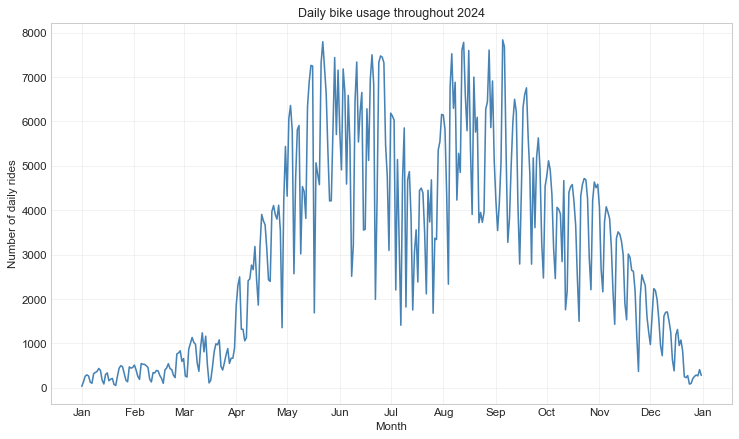

In [115]:
# Plot usage frequency
import matplotlib.dates as mdates

# Group by day
daily = trips.groupby(trips['started_at'].dt.date).size()

# Convert index to datetime (from date)
daily.index = pd.to_datetime(daily.index)

# Plot
plt.figure()
plt.plot(daily.index, daily.values, color='steelblue', linewidth=1.5)

# Format x-axis with months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Daily bike usage throughout 2024")
plt.xlabel("Month")
plt.ylabel("Number of daily rides")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/daily_ride_count.png')
plt.show()

**Figure 1:** Daily bike usage throughout 2024 shows clear seasonal patterns. Peak usage during early summer and early autumn, and reduced activity during summer vacation periods and winter months. 

> ✓ No problems detected in this column.

#### 1.2.2 Column `duration`
The `duration` column states the duration of the ride in seconds. 

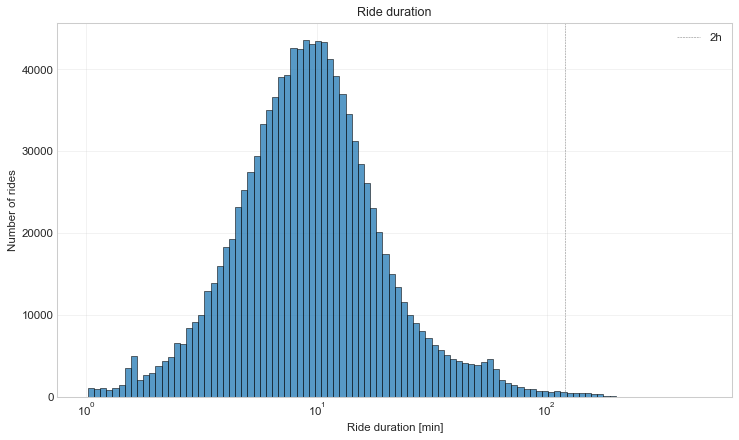

In [116]:
# Plot duration distribution, log scale helps
plt.figure()
trips_minutes = trips['duration']/60
sns.histplot(data=trips_minutes, bins=100, log_scale=True)
plt.title("Ride duration")
plt.xlabel("Ride duration [min]")
plt.axvline(120, c='grey', linewidth=0.5, linestyle='--', label="2h")
plt.legend(frameon=False)
plt.ylabel("Number of rides")
plt.tight_layout()
plt.show()

**Figure 2:** Distribution of ride duration (log scale) shows most trips last ~10 minutes.

In [117]:
print(f"""
There are {(trips[trips['duration']>7200]).size:,.0f} rides that exceed 2 hours.\nIt is likely that these are not actual rides but bikes that were unsuccessfully returned. These will be removed from the dataset.  
""")


There are 44,343 rides that exceed 2 hours.
It is likely that these are not actual rides but bikes that were unsuccessfully returned. These will be removed from the dataset.  



> ✓ No missing values.  
> → Remove rides longer than 2 hours. 

#### 1.2.3 Columns `start_station_id` & `end_station_id`
These columns state a unique id for each station. 

In [118]:
print(f"Number of start stations: {len(set(trips['start_station_id']))}")
print(f"Number of end stations: {len(set(trips['end_station_id']))}")

Number of start stations: 274
Number of end stations: 274


In [119]:
start_ids = set(trips['start_station_id'].unique())
end_ids = set(trips['end_station_id'].unique())

only_start = start_ids - end_ids
only_end = end_ids - start_ids

print(f"Start-only stations: {len(only_start)}")
print(f"End-only stations: {len(only_end)}")

Start-only stations: 0
End-only stations: 0


Check how many trips are **loops**, so trips where the start and end stations are identical. These might distort the picture. 

In [120]:
print(f"There are {len(trips[trips['start_station_id']==trips['end_station_id']]):,.0f} trips with identical start and end point. These will be discarded.")

There are 30,188 trips with identical start and end point. These will be discarded.


> ✓ No missing values.  
> → Remove loops

#### 1.2.3 Columns `start_station_name` & `end_station_name`

In [121]:
print(f"Number of start stations: {len(set(trips['start_station_name']))}")
print(f"Number of start stations: {len(set(trips['end_station_name']))}")

Number of start stations: 276
Number of start stations: 276


There are two more unique station names than station id's. 

In [122]:
start_names = set(trips['start_station_name'].unique())
end_names = set(trips['end_station_name'].unique())

only_start_names = start_names - end_names
only_end_names = end_names - start_names

print(f"Start-only station names: {len(only_start_names)}")
print(f"End-only station names: {len(only_end_names)}")

Start-only station names: 0
End-only station names: 0


In [123]:
start_name_map = (
    trips[['start_station_id', 'start_station_name']]
    .drop_duplicates()
    .groupby('start_station_id')['start_station_name']
    .nunique()
)

# IDs with >1 unique name
inconsistent_ids = start_name_map[start_name_map > 1]
print(f"Start station IDs with multiple names: {len(inconsistent_ids)}")
print(inconsistent_ids.head())

Start station IDs with multiple names: 2
start_station_id
608     2
1101    2
Name: start_station_name, dtype: int64


In [124]:
end_name_map = (
    trips[['end_station_id', 'end_station_name']]
    .drop_duplicates()
    .groupby('end_station_id')['end_station_name']
    .nunique()
)

# IDs with >1 unique name
inconsistent_ids = end_name_map[end_name_map > 1]
print(f"End station IDs with multiple names: {len(inconsistent_ids)}")
print(inconsistent_ids.head())

End station IDs with multiple names: 2
end_station_id
608     2
1101    2
Name: end_station_name, dtype: int64


In [125]:
df = trips[trips['start_station_id']==608]
df['start_station_name'].unique()

array(['Colletts gate', 'Diriks gate'], dtype=object)

In [126]:
df = trips[trips['start_station_id']==1101]
df['start_station_name'].unique()

array(['Stortingstunellen', 'Stortingstunnelen'], dtype=object)

> **Note:** Stations with IDs **608** and **1101** appear under multiple names. Station ID **608** is listed as both *Colletts gate* and *Diriks gate*, and **1101** as *Stortingstunellen* and *Stortingstunnelen*. These inconsistencies affect about 1% of entries. Use `station_id`as the unique key when creating the station table to ensure consistency.

#### 1.2.4 Colummns `start_station_latitude`, `end_station_latitude`, `start_station_longitude`, `end_station_longitude`

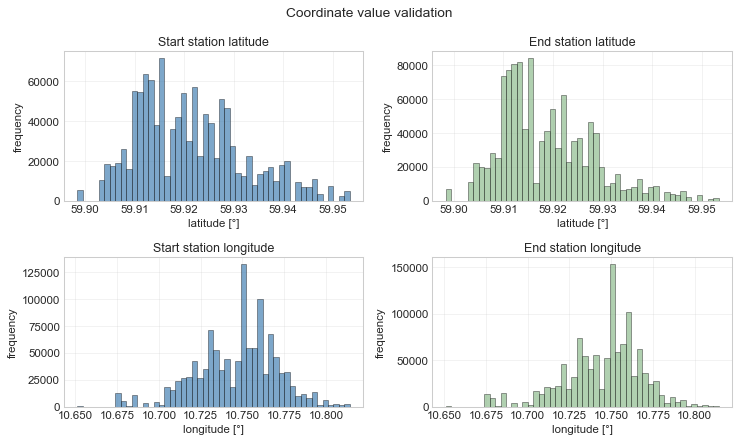

In [127]:
# Validate coordinate ranges
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

trips['start_station_latitude'].hist(ax=axs[0, 0], bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
axs[0, 0].set_title('Start station latitude')
axs[0, 0].set_xlabel('latitude [°]')
axs[0, 0].set_ylabel('frequency')
axs[0, 0].grid(True, alpha=0.3)

trips['end_station_latitude'].hist(ax=axs[0, 1], bins=50, color='darkseagreen', alpha=0.7, edgecolor='black', linewidth=0.5)
axs[0, 1].set_title('End station latitude')
axs[0, 1].set_xlabel('latitude [°]')
axs[0, 1].set_ylabel('frequency')
axs[0, 1].grid(True, alpha=0.3)

trips['start_station_longitude'].hist(ax=axs[1, 0], bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
axs[1, 0].set_title('Start station longitude')
axs[1, 0].set_xlabel('longitude [°]')
axs[1, 0].set_ylabel('frequency')
axs[1, 0].grid(True, alpha=0.3)

trips['end_station_longitude'].hist(ax=axs[1, 1], bins=50, color='darkseagreen', alpha=0.7, edgecolor='black', linewidth=0.5)
axs[1, 1].set_title('End station longitude')
axs[1, 1].set_xlabel('longitude [°]')
axs[1, 1].set_ylabel('frequency')
axs[1, 1].grid(True, alpha=0.3)

fig.suptitle('Coordinate value validation')

plt.tight_layout()
plt.show()

**Figure 3**: Coordinate validation shows that all latitude and longitude values fall within expected ranges for Oslo's geographic location.

#### Column audit summary

| Column                      | Notes                                                                 |
|-----------------------------|-----------------------------------------------------------------------|
| `started_at`, `ended_at`    | ✅ Valid timestamps, no missing values. |
| `duration`                  | ⚠️ No missing values, but contains outliers > 2 hours → to be removed in SQL. |
| `start_station_id`          | ✅ Valid IDs. However, 30,188 trips are loops (start = end) → to be removed. |
| `end_station_id`            | ✅ Valid IDs. Same note as above.                                    |
| `start_station_name`        | ⚠️ Mostly consistent. Two IDs (608 and 1101) map to multiple names. Will use the most common. |
| `end_station_name`          | ⚠️ Same as above. No major action needed if we trust IDs.            |
| `start_station_description` | ❌ Incomplete. Will be dropped in cleaning step.                 |
| `end_station_description`   | ❌ Same as above.                                                    |
| `start_station_latitude`    | ✅ All values present. Range appears valid.                          |
| `end_station_latitude`      | ✅ Same as above.                                                    |
| `start_station_longitude`   | ✅ All values present. Range appears valid.                          |
| `end_station_longitude`     | ✅ Same as above.                                                    |


#### Cleaning actions to apply in SQL

- Remove trips longer than 2 hours  
- Remove loops (start and end station ID are the same)  
- Drop `start_station_description` and `end_station_description`  

---
### 1.3 Cleaning in SQL
In this step, the dataset is cleaned and the issues identified during the exploration phase addressed.

The goal is to create two well-structured tables:
1. `trips_clean`: A filtered dataset without outliers or irrelevant columns, ready for analysis in pandas.
2. `stations`: A normalized table listing all stations in the system, containing consistent names, IDs, and geographic coordinates

#### 2.1 Create `trips_clean` table

In [128]:
# Remove rides longer than 2 hours (= 7200 sec)
# Remove loops
# Drop station descriptions

con.execute("""
CREATE OR REPLACE TABLE trips_clean AS
SELECT 
    * EXCLUDE (start_station_description, end_station_description)
FROM trips_raw
WHERE
    duration < 7200 AND
    start_station_id != end_station_id
""")
con.execute("CHECKPOINT")
print("Cleaned trips saved to DuckDB as 'trips_clean'");

Cleaned trips saved to DuckDB as 'trips_clean'


#### 1.4 Create `stations` table by extracting unique stations  
Build a `stations` table by combining all distinct start and end stations from the `trips_clean` table. This gives the full list of physical bike stations to enrich with elevation later.

In [129]:
con.execute("""
CREATE OR REPLACE TABLE stations AS
SELECT DISTINCT
    station_id,
    station_name,
    ROUND(lat, 5) AS lat,
    ROUND(lon, 5) AS lon
FROM (
    SELECT
        start_station_id AS station_id,
        start_station_name AS station_name,
        start_station_latitude AS lat,
        start_station_longitude AS lon
    FROM trips_clean

    UNION ALL

    SELECT
        end_station_id AS station_id,
        end_station_name AS station_name,
        end_station_latitude AS lat,
        end_station_longitude AS lon
    FROM trips_clean
)
ORDER BY station_id
""")

con.execute("CHECKPOINT")
print("Extracted and saved 'stations' table")

Extracted and saved 'stations' table


#### 1.5 Summary of cleaning steps
After cleaning the dataset we have:
- **`trips_clean`**: Filtered dataset
    - Removed rides longer than 2 hours and "loop" trips that started and ended at the same station.
    - Dropped unused station description fields.
- **`stations`:** List of all stations in the network
    - Extracted all unique stations from both trip endpoints. Will be enriched later (e.g. elevation).  
  
The dataset is now ready for analysis.

---
## 2. Phase 1: Topographical flow analysis
In this phase of the project, I'll investigate whether Oslo's topography influences bike usage patterns. Oslo has a natural gradient from sea level upwards, which suggests that cyclists might prefer downhill over uphill routes.  

**Questions to answer:**
1. Do cyclists prefer downhill routes? If so, by what margin?
2. How does elevation affect station imbalance?
3. Which specific stations require the most urgent daily rebalancing?

### 2.1 Enhancing data with elevation information
Before analyzing the effect of the terrain, I need to add elevation information based on the geographic location of each bike station in the system. This can easily be achieved using the free api service "open-meteo.com".

In [130]:
# Read stations table and add elevation data
csv_path = "../db/stations_with_elevation.csv"

def get_elevation(row):
    lat = row['lat']
    lon = row['lon']
    
    response = requests.get(f"https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}")
    data = response.json()
    return data['elevation'][0]

if os.path.exists(csv_path):
    print("Found existing data. Loading from csv.")
    stations = pd.read_csv(csv_path)
else:
    print("No csv found. Fetching elevation data from API.")
    stations = con.execute("SELECT * FROM stations").df()
    stations = stations.drop_duplicates(subset='station_id')
    stations['elevation'] = stations.apply(get_elevation, axis=1)
    stations.to_csv(csv_path, index=False)

print("Elevation received for all stations.")

Found existing data. Loading from csv.
Elevation received for all stations.


In [131]:
# Save elevation data to database
con.register("stations_df", stations)
con.execute("CREATE OR REPLACE TABLE stations AS SELECT * FROM stations_df")
con.unregister("stations_df");

In [132]:
# Enrich trips with elevation data (overwriting original)
con.execute("""
CREATE OR REPLACE TABLE trips_clean AS
SELECT
    t.*,   
    s_start.elevation AS start_elevation,
    s_end.elevation AS end_elevation,
    s_end.elevation - s_start.elevation AS elevation_diff
FROM trips_clean t
JOIN stations s_start ON t.start_station_id = s_start.station_id
JOIN stations s_end ON t.end_station_id = s_end.station_id
""")

con.execute("CHECKPOINT");

#### Loading Analysis-Ready Data into pandas
Now that the data has been cleaned and enriched with elevation information, it is ready to be loaded into pandas for further analysis.

In [133]:
# Load enriched data into pandas for analysis
con = duckdb.connect("../db/bysykkel_2024.duckdb")
trips = con.execute("SELECT * FROM trips_clean").df()
stations = con.execute("SELECT * FROM stations").df()
con.close()

print(f"Loaded {len(trips):,} clean trips and {len(stations)} stations")
print(f"Data spans from {trips['started_at'].min()} to {trips['started_at'].max()}")

# Quick check of our elevation data
print(f"\nElevation range: {stations['elevation'].min():.1f}m to {stations['elevation'].max():.1f}m")

Loaded 1,110,272 clean trips and 274 stations
Data spans from 2024-01-01 04:08:14.939000 to 2024-12-31 23:19:17.936000

Elevation range: 1.0m to 144.0m


### 2.2 Grouping stations
Some bike stations in Oslo are placed extremely close together, sometimes just across the road or even side by side. In practice, these stations act as one single hub, which is why I am manually grouping them into station clusters to get a clearer view of bike flows. This will reduce visual clutter when visualizing the network later, and it will be easier to make out where the hotspots are.  

After grouping:
-  The `stations` table is updated to consolidate selected clusters. Coordinates are replaced by the average (centroid) of grouped locations. 
- The `trips` table is updated to reflect the new grouped station IDs and coordinates. 
- "Loop" rides (trips starting and ending at the same station) are removed again since grouping may have introduced new ones. 

In [134]:
station_groups = {
    'Tjuvholmen': [534, 479],
    'Aker Brygge': [1755, 2358, 558, 2357],
    'Vippetangen': [452, 441],
    'Oslo S': [443, 392, 599],
    'Jernbanetorget': [478, 2328], 
    'Torggata': [437, 489],
    'Alexander Kiellands Plass': [421, 444, 617],
    'Arkaden': [545, 577],
    'Brugata / Vaterlandsparken': [491, 495],
    'Schous Plass': [401, 423, 463],

}

# Create mapping of old ID to new ID
id_mapping = {}
for group_name, station_ids in station_groups.items():
    new_id = station_ids[0] # Use first id for all stations in the group
    for id in station_ids:
        id_mapping[id] = new_id

# Create grouped dataframe
stations_grouped = []

for group_name, station_ids in station_groups.items():
    station_cluster = stations[stations['station_id'].isin(station_ids)]
    stations_grouped.append({
        'station_id': station_ids[0],
        'station_name': group_name,
        'lat': station_cluster['lat'].mean(),
        'lon': station_cluster['lon'].mean(),
        'elevation': station_cluster['elevation'].mean()
        
    })

# all_grouped_ids = []
# for _, ids in station_groups.items():
#     for id in ids:
#         all_grouped_ids.append(id)
all_grouped_ids = [id for ids in station_groups.values() for id in ids]
ungrouped_stations = stations[~stations['station_id'].isin(all_grouped_ids)]

for _, station in ungrouped_stations.iterrows():
    stations_grouped.append({
        'station_id': station['station_id'],
        'station_name': station['station_name'],
        'lat': station['lat'],
        'lon': station['lon'],
        'elevation': station['elevation']
    })
stations = pd.DataFrame(stations_grouped)

# Create lookup tables
name_lookup = stations.set_index('station_id')['station_name'].to_dict()
lat_lookup = stations.set_index('station_id')['lat'].to_dict()
lon_lookup = stations.set_index('station_id')['lon'].to_dict()

trips['start_station_id'] = trips['start_station_id'].map(lambda x: id_mapping.get(x, x))
trips['end_station_id'] = trips['end_station_id'].map(lambda x: id_mapping.get(x, x))

trips['start_station_name'] = trips['start_station_id'].map(name_lookup)
trips['end_station_name'] = trips['end_station_id'].map(name_lookup)
trips['start_station_latitude'] = trips['start_station_id'].map(lat_lookup)
trips['start_station_longitude'] = trips['start_station_id'].map(lon_lookup)
trips['end_station_latitude'] = trips['end_station_id'].map(lat_lookup)
trips['end_station_longitude'] = trips['end_station_id'].map(lon_lookup)

# Remove loops
trips = trips[trips['start_station_id']!=trips['end_station_id']]

### 2.2 Calculating trip distance and gradient
To understand cyclist preferences, two metrics are calculated for each trip:  
  
- **Distance**: The physical distance between start and end stations using the haversine formula
- **Gradient**: The slope percentage (elevation change divided by distance)  
  
Using these metrics, each trip can be categorized as uphill, downhill, or flat. This helps analyze route preferences and quantify any bias toward downhill travel.

In [135]:
# Compute travel distance and gradient

from haversine import haversine, Unit

def compute_distance(row):
    start = (row['start_station_latitude'], row['start_station_longitude'])
    end = (row['end_station_latitude'], row['end_station_longitude'])
    return haversine(start, end, unit=Unit.METERS)

trips["distance"] = trips.apply(compute_distance, axis=1)

def compute_gradient(row):
    if row['distance'] == 0:
        return np.nan
    return row['elevation_diff'] / row['distance'] * 100

trips["gradient"] = trips.apply(compute_gradient, axis=1)

### 2.3 Do cyclists prefer downhill routes?
Now we're ready to analyze whether there's a preference for downhill vs. uphill travel.

#### 2.3.1 Gradient distribution analysis
To understand the overall terrain preferences, we'll first examine the distribution of trip gradients across all rides.

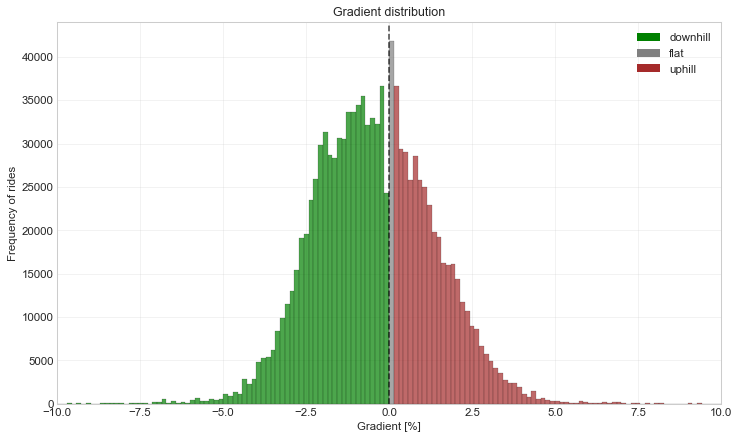

In [136]:
# Plot histogram of trip gradients
plt.figure()
n, bins, patches = plt.hist(trips["gradient"], 
                            bins=200, 
                            edgecolor="black", alpha=0.7, linewidth=0.2)

for i, patch in enumerate(patches):
    if bins[i] < 0:
        patch.set_facecolor("green")
    elif bins[i] > 0:
        patch.set_facecolor("brown")
    else:
        patch.set_facecolor("grey")

plt.axvline(x=0, color="black", linestyle="--", alpha=0.7)
plt.xlim([-10, 10])
plt.title("Gradient distribution")
plt.xlabel("Gradient [%]")
plt.ylabel("Frequency of rides")

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="green", label="downhill"),
    Patch(facecolor="grey", label="flat"),
    Patch(facecolor="brown", label="uphill")
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

**Figure 4**: Distribution of gradients for all trips clearly favors negative values, indicating that downhill travel is more popular than uphill. The distinct peak at 0% represents trips along flat terrain, likely leisrue rides along the waterfront. 

In [137]:
# gradient stats
median_gradient = trips["gradient"].mean()
n_uphill = len(trips[trips['gradient']>0])
n_downhill = len(trips[trips['gradient']<0])
n_flat = len(trips[trips['gradient']==0])
n_total = len(trips)

percent_uphill = n_uphill / n_total * 100
percent_downhill = n_downhill / n_total * 100
percent_flat = n_flat / n_total * 100
net_bias = (n_downhill - n_uphill) / n_total * 100
relative_increase = (n_downhill - n_uphill) / n_uphill * 100

summary = f"""
gradient median = {median_gradient:.2f}%
downhill trips: {percent_downhill:.1f}%
uphill trips: {percent_uphill:.1f}%
flat trips: {percent_flat:.1f}%
net bias towards downhill: {net_bias:.1f}%
relative increase: {relative_increase:.1f}%
"""
print(summary)


gradient median = -0.44%
downhill trips: 59.6%
uphill trips: 38.8%
flat trips: 1.6%
net bias towards downhill: 20.7%
relative increase: 53.4%



Looking at the histogram and the statistics, there are several key patterns in Oslo's bike sharing usage:  
  
**Visual observations:**  
- Downhill rides (negative gradients) are clearly more frequent than uphill rides.  
- There's a pronounced spike at gradient 0%, which likely represents popular rides along the flat waterfront paths.
- The distribution shows a clear skew towards negative gradients. This indicates a preference for downhill travel. 
  
**Metrics:**
Computing the metrics of all trips reveals the following results:
- **Downhill trips**: 59.6% of all rides (gradient < 0%)
- **Uphill trips**: 38.8% of all rides (gradient > 0%) 
- **Flat trips**: 1.6% of all rides (gradient = 0%)
- **Mean gradient**: -0.44% (indicating an overall downhill bias)  
  
The data shows that **downhill trips are 53% more common than uphill trips** (59.5% vs. 38.8%). This confirms that people avoid uphill rides, making it much harder to keep bikes evenly distributed across town. 

#### 2.3.2 Distance and duration analysis
Counting uphill vs. downhill trips alone might be misleading. Another interesting detail to look into is how much total distance and time cyclists spend going uphill vs. downhill.

In [138]:
# Add a column for the slope type
def categorize_slope(slope):
    if slope < 0:
        return "downhill"
    elif slope > 0:
        return "uphill"
    else:
        return "flat"
    
trips['slope_type'] = trips['gradient'].apply(categorize_slope)

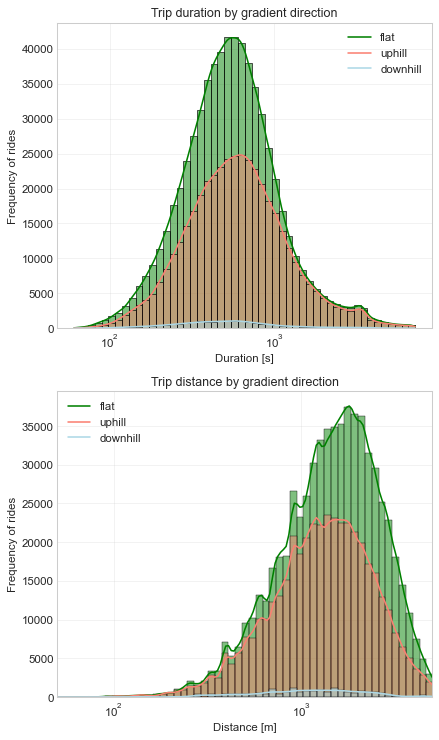

In [139]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,10))

# Duration histogram
sns.histplot(data=trips, x='duration', hue='slope_type', 
             hue_order=['flat', 'uphill', 'downhill'], 
             bins=50, kde=True, log_scale=True, ax=ax1, legend=True,
             palette=['lightblue', 'salmon', 'green'])
ax1.set_title("Trip duration by gradient direction")
ax1.set_xlabel("Duration [s]")
ax1.set_ylabel("Frequency of rides")
ax1.legend(title="", labels=["flat", "uphill", "downhill"])


# Distance histogram  
sns.histplot(data=trips, x='distance', hue='slope_type',
             hue_order=['flat', 'uphill', 'downhill'], 
             bins=80, kde=True, log_scale=True, ax=ax2, legend=True,
             palette=['lightblue', 'salmon', 'green'])
ax2.set_title("Trip distance by gradient direction") 
ax2.set_xlabel("Distance [m]")
ax2.set_ylabel("Frequency of rides")
ax2.legend(title="", labels=["flat", "uphill", "downhill"])
plt.xlim([50, 5000])

plt.tight_layout()
plt.show()

**Figure 5**: Trip duration and distance distribution by gradient direction (log scale). Downhill trips (green) are not only more frequent but also cover greater distances and longer durations than uphill trips (orange). 

In [140]:
# Calculate statistics
usage_summary = trips.groupby('slope_type').agg({
    'duration': ['sum', 'mean', 'count'],
    'distance': ['sum', 'mean']}).round(1)
usage_summary.columns = ['Total duration [s]', 'Average duration [s]', 'Number of rides', 'Total distance [m]', 'Average distance [m]']
print(usage_summary.to_string())

# Calculate comparisons (downhill vs. uphill)
duration_up = usage_summary.loc['uphill', 'Total duration [s]']
duration_down = usage_summary.loc['downhill', 'Total duration [s]']
distance_up = usage_summary.loc['uphill', 'Total distance [m]']
distance_down = usage_summary.loc['downhill', 'Total distance [m]']

# Calculate percentage differences
duration_diff_pct = (duration_down - duration_up) / duration_up * 100
distance_diff_pct = (distance_down - distance_up) / distance_up * 100

# Per-trip comparison
avg_duration_up = usage_summary.loc['uphill', 'Average duration [s]']
avg_duration_down = usage_summary.loc['downhill', 'Average duration [s]']
avg_distance_up = usage_summary.loc['uphill', 'Average distance [m]']
avg_distance_down = usage_summary.loc['downhill', 'Average distance [m]']

time_per_trip_diff = (avg_duration_down - avg_duration_up) / avg_duration_down * 100
distance_per_trip_diff = (avg_distance_down - avg_distance_up) / avg_distance_up * 100

print("\nKey comparisons")
print(f"""
      - Downhill trips account for {duration_diff_pct:.1f}% more total ride time.
      - Downhill trips cover {distance_diff_pct:.1f}% more total distance.
      - Uphill trips take on average {abs(time_per_trip_diff):.1f}% longer per trip.
      - Downhill trips cover {distance_per_trip_diff:.1f}% more distance per trip.
      """)


            Total duration [s]  Average duration [s]  Number of rides  Total distance [m]  Average distance [m]
slope_type                                                                                                     
downhill             465007161                 704.0           660504        1.121484e+09                1697.9
flat                  12978608                 721.7            17983        2.411154e+07                1340.8
uphill               337796652                 784.5           430591        6.666432e+08                1548.2

Key comparisons

      - Downhill trips account for 37.7% more total ride time.
      - Downhill trips cover 68.2% more total distance.
      - Uphill trips take on average 11.4% longer per trip.
      - Downhill trips cover 9.7% more distance per trip.
      


#### 2.3.3 Summary: Evidence of downhill preference
This analysis provides strong evidence that cyclists prefer downhill routes accross multiple metrics:

**Trip distribution:**
- 59.6% of trips go downhill vs. 38.8% go uphill (53% more common).
- Mean gradient of -0.44 indicates overall bias towards downhill travel.

**Total system usage:**
- Downhill trips account for 37.7% more total ride time.
- Downhill trips cover 68.2% more total distance.

**Individual trip properties:**
- Uphill trips take on average 11.4% longer.
- Downhill trips cover on average 9.7% more distance.

**Answer to question 1:** Yes, cyclists show a strong preference towards downhill routes.

### 2.4 How does elevation affect station imbalance?

Having established that customers have a strong preference for downhill trips, it is now time to investigate how that affects the net flow of bikes.  

#### 2.4.1 Compute net flux per station
I will start out by computing the **net flux** per station:  
```
net flux = arriving bikes - departing bikes
```
This metric shows whether a station tends to accumulate or lose bikes over time. A station with a negative net flux is consistently losing bikes and acts as an **exporter**, while a positive net flux indicates it acts as an **importer**.

In [141]:
# Compute the net flux per station
flux_out = trips.groupby('start_station_id').size().rename('departures')
flux_in = trips.groupby('end_station_id').size().rename('arrivals')

station_flux = flux_out.to_frame().join(flux_in.to_frame(), how='outer').fillna(0)
station_flux['net_flux'] = station_flux['arrivals'] - station_flux['departures']
station_flux['total_usage'] = station_flux['arrivals'] + station_flux['departures']
station_flux['net_flux_daily'] = station_flux['net_flux'] / 365
station_flux['total_usage_daily'] = station_flux['total_usage'] / 365
station_flux['departure_share'] = station_flux['departures'] / station_flux['total_usage']

station_flux = stations.join(station_flux, how="outer", on="station_id").fillna(0)

#### 2.4.2 The impact of elevation on station balance
Now let's explore whether elevation is a key factor in determining whether a station tends to **import** or **export** bikes. To do this, we'll plot each station's **net flux** against its **elevation** and look for patterns in the relationship.

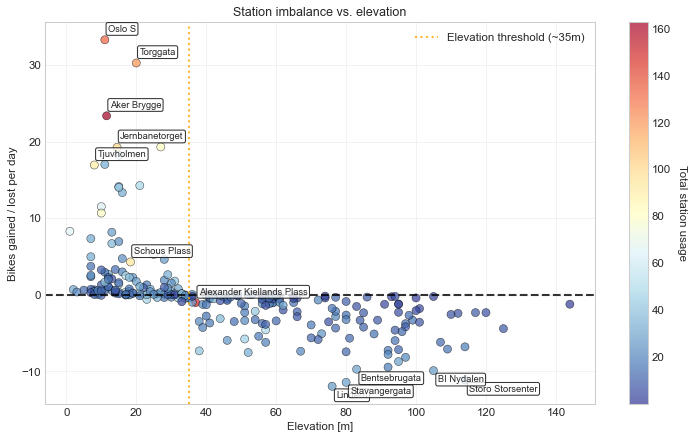

In [142]:
scatter = plt.scatter(station_flux['elevation'], station_flux['net_flux_daily'],
                      c=station_flux['total_usage_daily'],
                      s=60, alpha=0.7, cmap='RdYlBu_r',
                      edgecolors='black', linewidths=0.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Total station usage', rotation=270, labelpad=15)

plt.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.8)
plt.axvline(35, color='orange', linestyle=':', linewidth=2, alpha=0.8, label='Elevation threshold (~35m)')

plt.xlabel('Elevation [m]')
plt.ylabel('Bikes gained / lost per day')
plt.title('Station imbalance vs. elevation')
plt.legend()


# Top importers and exporters for labelling
top_stations = station_flux.nlargest(7, 'total_usage_daily')
top_exporters = station_flux.nsmallest(5, 'net_flux_daily')


# Add station labels
for _, station in top_stations.iterrows():
    plt.annotate(station['station_name'], 
                (station['elevation'], station['net_flux_daily']),
                xytext=(3, 8), textcoords='offset points',
                fontsize=9, ha='left', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

for _, station in top_exporters.iterrows():
    plt.annotate(station['station_name'], 
                (station['elevation'], station['net_flux_daily']),
                xytext=(4, -11), textcoords='offset points',
                fontsize=9, ha='left', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('../outputs/imbalance_vs_elevation.png')
plt.savefig('../images/imbalance_vs_elevation.png', dpi=150, bbox_inches='tight')
plt.show()

**Figure 6**: Station imbalance vs. elevation reveals a clear negative correlation (-0.55). Stations below ~35m elevation consistently import bikes (positive flux) while those above export bikes (negative flux). 

In [143]:
print(f"The correlation between elevation and net flux is {station_flux['elevation'].corr(station_flux['net_flux']):.2f}")

The correlation between elevation and net flux is -0.55


This figure clearly demonstrates how elevation causes station imbalances in Oslo's bike sharing system.  

**Key observations:**
- **Above ~35m elevation**: Stations predominantly export bikes (negative net flux), losing around 5 to 10 bikes per day.
- **Below ~35m elevation**: Stations predominantly import bikes (positive net flux), gaining up to 20 bikes per day. 
- **Correlation**: The relationship has a correlation of -0.55, which indicates a moderately strong relationship between elevation and station balance.

**Interpretation:**  
Bikes naturally "flow" downhill through the system and accumulate near sea level. This creates a systematic daily imbalance, where:
- Higer elevation stations consistently need bike restocking.
- Lower elevation stations consistenly need bikes removed to create docking space.
- The ~35m elevation mark represents a "watershed" for bike flow in the system. 

#### 2.4.3 Geographic distribution of imbalances
Having established that there's a strong relationship between elevation and station imbalance, let's now visualize these imbalances on a map.  
  
  The interactive map below shows all bike stations with:  
  - **Marker size**: Proportional to total daily usage (larger circles = busier station)
  - **Marker color**: Indicates imbalance of the station and magnitude
    - **Red stations**: Net exporters (lose bikes daily, need restocking)
    - **Green stations**: Net importers (gain bikes daily, need bike removal)
    - **Color intensity**: Darker colors indicate larger daily imbalances  

In [144]:
# Get top 10 exporters and importers
top_exporters = station_flux.nsmallest(10, 'net_flux_daily')
top_importers = station_flux.nlargest(10, 'net_flux_daily')
critical_ids = set(top_exporters['station_id'].tolist() + top_importers['station_id'].tolist())

In [145]:
# Create interactive Folium map of Oslo to spatially demonstrate the behaviour where bikes are flowing

def get_color(flux_value):
    if flux_value > 2.7:
        return '#1a9850'     # Dark green - Heavy importer
    elif flux_value > 0.5:
        return 'yellowgreen' # Light green - Light importer  
    elif flux_value >= -0.5:
        return 'gray'        # Gray - Balanced (±0.5 bikes/day)
    elif flux_value > -2.7:
        return '#fc8d59'     # Orange - Light exporter
    else:
        return '#d73027'     # Red - Heavy exporter
    
def get_radius(total_usage):
    # Normalize usage
    return np.interp(total_usage,
                     (station_flux['total_usage_daily'].min(), station_flux['total_usage_daily'].max()),
                     (2, 17))

flux_map = folium.Map(location=oslo_coordinates, zoom_start=zoom, tiles="CartoDB positron")

# First, add all non-critical stations
for index, row in station_flux.iterrows():
    if row['station_id'] not in critical_ids:  # Only non-critical stations
        popup_content = f"""
        Station: {row['station_name']} <br>
        Elevation: {row['elevation']:.0f}m <br>
        Departures: {row['departures']/365:.0f}/day <br>
        Arrivals: {row['arrivals']/365:.0f}/day <br>
        Total Usage: {row['total_usage_daily']:.0f}/day <br>
        Net Flux: {row['arrivals']/365 - row['departures']/365:+.1f}/day
        """
        
        # Add marker
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=get_radius(row['total_usage_daily']),
            color=get_color(row['net_flux_daily']),
            fill=True,
            fill_color=get_color(row['net_flux_daily']),
            fill_opacity=0.8,
            weight=1,
            popup=folium.Popup(popup_content, max_width=300)
        ).add_to(flux_map)

# Then add critical stations on top
for index, row in station_flux.iterrows():
    if row['station_id'] in critical_ids:  # Only critical stations
        popup_content = f"""
        <b>⚠️ CRITICAL STATION</b><br>
        Station: {row['station_name']} <br>
        ID: {row['station_id']} <br>
        Elevation: {row['elevation']:.0f}m <br>
        Departures: {row['departures']/365:.0f}/day <br>
        Arrivals: {row['arrivals']/365:.0f}/day <br>
        Total Usage: {row['total_usage_daily']:.0f}/day <br>
        <b>Net Flux: {row['arrivals']/365 - row['departures']/365:+.1f}/day</b>
        """
        
        # Add marker
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=get_radius(row['total_usage_daily']),
            color='black',
            fill=True,
            fill_color=get_color(row['net_flux_daily']),
            fill_opacity=0.9,  # Slightly higher opacity
            weight=3,
            popup=folium.Popup(popup_content, max_width=300)
        ).add_to(flux_map)

# Updated legend to include critical stations
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 175px; height: 170px; 
            background-color:white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 8px">
<b>Net Flux</b><br>
<span style="color:#d73027">●</span> Heavy export<br>
<span style="color:#fc8d59">●</span> Light export<br>
<span style="color:gray">●</span> Balanced<br>
<span style="color:yellowgreen">●</span> Light import<br>
<span style="color:#1a9850">●</span> Heavy import<br>
<hr style="margin: 5px 0;">
<b>⚫</b> = Top 10 critical station
</div>
'''

flux_map.get_root().html.add_child(folium.Element(legend_html))

flux_map.save('../outputs/oslo_flux_map.html')
flux_map

**Figure 7**: Interactive map of Oslo's bike station network showing which stations tend to import and export. Green stations import bikes, red stations export bikes. The marker size indicates the total daily usage. Black-bordered markers highlight the top 5 importers and exporters. The map shows a clear geographic pattern: Central Oslo stations consistently accumulate bikes while peripheral stations export them. Clicking on a marker will reveal station info.

#### 2.4.4 Summary: Geographic imbalance

The interactive map above shows the geographic pattern of the imbalanced flow of bikes in the bike sharing system.  

**Clear spatial patterns:**
- **Northern/outer areas** (higher elevation): Dominated by red stations that consistantly export bikes - *bike sources*
- **Central/southern areas** (lower elevation): Dominated by green stations that consistantly import bikes - *bike sinks*
- **Intermediate elevation areas**: Most stations are balanced (gray), creating a transition zone between exporter and importer areas - *transition zone*

**Geographic "watershed":**
There is a clear three-zone pattern: a green core of heavy importers, surrounded by gray balanced stations at intermediate elevations, surrounded by red exporter stations at higher elevations. There is a daily flow of bikes from higher elevation down into the city center and lower elevation regions.  

**Important note**: This analysis represents a yearly average across all seasons and times of day. The actual rebalancing challenges may be significantly more pronounced during peak times (rush hours, summer months, weekends)  

This visualization demonstrates that bike rebalancing in Oslo is not a random maintenance, but follows a clear geographical pattern. 

**Answer to question 2:** Elevation systematically affects station imbalance by creating predictable daily bike flows from higher to lower elevations, with stations above ~35m consistently exporting bikes while those below consistently import them.

### 2.5 Which stations require the most urgent daily rebalancing?
Now that we've seen how elevation causes imbalances, let's identify the specific stations that create the most critical challenges.

In [146]:
# Display the top 10 heavist importer and exporter stations
print("TOP 10 EXPORTER STATIONS (Need daily restocking)")
print("="*70)
exporters_display = top_exporters[['station_name', 'elevation', 'net_flux_daily', 'total_usage_daily']].copy()
exporters_display.columns = ['Station', 'Elevation [m]', 'Bikes lost daily', 'Total daily usage']
exporters_display['Bikes lost daily'] = exporters_display['Bikes lost daily'].round(1).abs()
exporters_display['Total daily usage'] = exporters_display['Total daily usage'].round(1)
print(exporters_display.to_string(index=False))
print(f"\nTotal daily restocking need: {top_exporters['net_flux_daily'].abs().sum():.0f} bikes")
print(f"Average elevation: {top_exporters['elevation'].mean():.1f}m")

print("\nTOP 10 IMPORTER STATIONS (Need daily removal)")
print("="*70)
importers_display = top_importers[['station_name', 'elevation', 'net_flux_daily', 'total_usage_daily']].copy()
importers_display.columns = ['Station', 'Elevation [m]', 'Bikes gained daily', 'Total daily usage']
importers_display['Bikes gained daily'] = importers_display['Bikes gained daily'].round(1)
importers_display['Total daily usage'] = importers_display['Total daily usage'].round(1)
print(importers_display.to_string(index=False))
print(f"\nTotal daily removal need: {top_importers['net_flux_daily'].abs().sum():.0f} bikes")
print(f"Average elevation: {top_importers['elevation'].mean():.1f}m")

# Impact summary
total_critical_flux = abs(top_exporters['net_flux_daily'].sum()) + top_importers['net_flux_daily'].sum()
pct_of_stations = 20 / len(stations) * 100

print(f"""
OPERATIONAL IMPACT:
- These 20 stations ({pct_of_stations:.1f}% of network) require moving ~{total_critical_flux:.0f} bikes daily.
- Elevation difference between critical exporters and importers: {top_exporters['elevation'].mean() - top_importers['elevation'].mean():.0f}m
- This represents the minimum daily rebalancing operation just to maintain these 20 stations. 
""")

TOP 10 EXPORTER STATIONS (Need daily restocking)
                  Station  Elevation [m]  Bikes lost daily  Total daily usage
                  Lindern           76.0              12.0               27.0
            Stavangergata           80.0              11.4               28.0
         Storo Storsenter          114.0              11.1               29.3
               BI Nydalen          105.0               9.9               26.8
            Bentsebrugata           83.0               9.7               29.2
            Bjølsen mølle           92.0               9.5               18.8
        Bjølsen Studentby           95.0               8.7               28.3
Hans Nielsen Hauges plass           97.0               8.2               21.3
 Georg Morgenstiernes hus           92.0               7.8               20.7
          Majorstua skole           52.0               7.5               32.8

Total daily restocking need: 96 bikes
Average elevation: 88.6m

TOP 10 IMPORTER STATIONS (Ne

### 2.6 Summary: The impact of topography on Oslo's bike sharing system

Our topographical analysis shows that Oslo's terrain creates complicated challenges for system operators:

**Key finding 1: Strong downhill preference**
- Cyclists are 53% more likely to choose downhill routes (59.5% vs 38.8% of trips)
- Downhill trips cover 68% more total distance and 38% more ride time
- This creates a system-wide "gravity bias" with a mean gradient of -0.44%

**Key finding 2: Elevation-driven station imbalances**
- Moderately strong negative correlation (-0.55) between elevation and daily net flux
- Critical elevation threshold at ~35m separates bike exporters from importers
- Geographic pattern: red (exporter) periphery → gray (balanced) middle → green (importer) core

**Key finding 3: Concentrated rebalancing needs**
- Top 10 exporters (avg. 54m elevation) lose 75 bikes daily combined
- Top 10 importers (avg. 17m elevation) gain 92 bikes daily combined  
  
This analysis proves that Oslo's bike rebalancing isn't random maintenance but a predictable daily battle against gravity. The result? Bikes constantly flow downhill, and someone has to truck them back up again. 
  
The topographical analysis has revealed WHERE bikes flow. Next, we'll examine the network structure to understand HOW bikes move through the system and which routes are the most popular.

---
## 3. Phase 2: Network structure analysis
The previous section clearly showed that Oslo's topography creates a significant flow from higher to lower elevations. The next step is to investigate *how* bikes move through the city. While elevation gives us a general idea of the direction of the flow, this analysis will reveal which exact pathways are most commonly used.  
  
Network analysis treates the bike sharing system as a complex web of interconnected stations. Each trip creates a weighted link between locations. Using this technique allows us to understand which stations serve as bike magnets, which routes are most popular, and where the areas for bike export and import are located.  
  
Key questions to answer:  
1. Which stations are most important in the network?
2. What are the most important pathways for bike travel?
3. How is the bike network organized across Oslo?

### 3.1 Building the network graph
The first step is to define the network graph where stations are nodes and trips act as weighted edges between them.

In [147]:
import networkx as nx

# Create bidirectional graph
G = nx.Graph()

# Add stations as nodes to graph
for _, station in stations.iterrows():
    G.add_node(station['station_id'],
               name=station['station_name'],
               lat=station['lat'],
               lon=station['lon'],
               elevation=station['elevation'])

# Add trips between stations as edges, with frequency of route as weight
trip_counts = trips.groupby(['start_station_id', 'end_station_id']).size().reset_index(name='weight')
trip_counts = trip_counts.sort_values('weight', ascending=False)#.head(100)

for _, trip in trip_counts.iterrows():
    G.add_edge(trip['start_station_id'],
               trip['end_station_id'],
               weight=trip['weight'])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 259
Number of edges: 30274


### 3.2 Which stations are the most important?
To figure out which stations are the most important, we can calculate a few network metrics:  
- **PageRank**: Identifies stations that are well-connected to other well-connected stations ("hubs"). This metric correlates very well with total station usage. 
- **Degree centrality**: Counts how many direct connections a station has to other stations. This metric has a wide plateau, since most stations are connected to most others over the course of the year.

In [148]:
# Calculate metrics
pagerank = nx.pagerank(G, weight='weight')
degree_centrality = dict(G.degree())  # Number of unique connections

# Write to stations table
station_flux['pagerank'] = station_flux['station_id'].map(pagerank)
station_flux['degree_centrality'] = station_flux['station_id'].map(degree_centrality)

In [149]:
# Find top n stations
n = 10
top_pagerank_stations = station_flux.nlargest(n, 'pagerank')
top_centrality_stations = station_flux.nlargest(n, 'degree_centrality')
print("TOP 10 MOST IMPORTANT STATIONS (by PageRank)")
print("=" * 60)

for i, (idx, station) in enumerate(top_pagerank_stations.iterrows(), 1):
    print(f"{i:2d}. {station['station_name']}")
    print(f"    PageRank: {station['pagerank']:.4f}")
    print()

TOP 10 MOST IMPORTANT STATIONS (by PageRank)
 1. Aker Brygge
    PageRank: 0.0248

 2. Alexander Kiellands Plass
    PageRank: 0.0217

 3. Oslo S
    PageRank: 0.0187

 4. Torggata
    PageRank: 0.0166

 5. Jernbanetorget
    PageRank: 0.0142

 6. Tjuvholmen
    PageRank: 0.0139

 7. Schous Plass
    PageRank: 0.0136

 8. Helga Helgesens plass
    PageRank: 0.0118

 9. Kirkeristen
    PageRank: 0.0116

10. Sukkerbiten
    PageRank: 0.0100



### 3.3 What are the most critical pathways?
Next, let's find out what the most frequent routes through the city are. This can be done by taking all edges from the network graph and sorting them by the number of trips. This gives a list of the top 15 most popular connections between stations. Below are the most popular routes.

In [150]:
# Get all edges with their weights (trip counts)
all_edges = [(start, end, data['weight']) for start, end, data in G.edges(data=True)]

# Sort by weight (trip count) descending
popular_routes = sorted(all_edges, key=lambda x: x[2], reverse=True)

# Convert to readable format
top_routes = []
for start, end, weight in popular_routes[:20]:  # Top 20
    route_info = {
        'from': G.nodes[start]['name'],
        'to': G.nodes[end]['name'],
        'trip_count': weight,
        'from_elevation': G.nodes[start]['elevation'],
        'to_elevation': G.nodes[end]['elevation'],
        'gradient': 'downhill' if G.nodes[end]['elevation'] < G.nodes[start]['elevation'] else 'uphill'
    }
    top_routes.append(route_info)

# Display as DataFrame
routes_df = pd.DataFrame(top_routes)
print("TOP 15 MOST POPULAR CONNECTIONS")
print("=" * 70)

for i, (idx, route) in enumerate(routes_df.head(15).iterrows(), 1):
    print(f"{i:2d}. {route['from']} ↔ {route['to']}")
    print(f"    {route['trip_count']:,} trips")
    print()

TOP 15 MOST POPULAR CONNECTIONS
 1. Vippetangen ↔ Oslo S
    1,922 trips

 2. Oslo S ↔ Sukkerbiten
    1,395 trips

 3. Aker Brygge ↔ Saga Kino
    1,233 trips

 4. Aker Brygge ↔ Oslo S
    1,024 trips

 5. Tjuvholmen ↔ Frognerstranda
    934 trips

 6. Torggata ↔ Alexander Kiellands Plass
    934 trips

 7. Jernbanetorget ↔ Alexander Kiellands Plass
    759 trips

 8. Oslo S ↔ Kværnerbyen
    688 trips

 9. Aker Brygge ↔ Torggata
    678 trips

10. Jernbanetorget ↔ Schous Plass
    637 trips

11. Vippetangen ↔ Jernbanetorget
    629 trips

12. Torggata ↔ Olaf Ryes plass
    605 trips

13. Aker Brygge ↔ Vippetangen
    586 trips

14. Schous Plass ↔ Botanisk Hage sør
    574 trips

15. Aker Brygge ↔ Kirkeristen
    564 trips



The most popular routes are short rides along the waterfront, connecting popular areas like Aker Brygge, Vippetangen, Tjuvholmen and Oslo S. These rides are most likely leisure-oriented.  
  
However, these top connections only account for about **1% of all trips** in the dataset. Even though they dominate the ranking by absolute count, they don't represent the typical bike-sharing usage pattern.  
  
Later in the analysis, we will see that weekday usage, particularly during commuting hours, dominates the overall flow. The system is used for far more than just leisure rides along the waterfront, as the above ranking might suggest. 

### 3.4 How is the bike network organized across Oslo
In order to visually inspect the structure of the network, let's visualize it by drawing the top 800 connections and the top 20 most popular stations:

In [151]:
# Oslo bike network: Core vs. feeder stations

n_edges = 600
network_flux_map = folium.Map(location=oslo_coordinates, zoom_start=zoom, tiles='CartoDB positron')

top_edges = sorted(
    G.edges(data=True),
    key=lambda x: x[2]['weight'],
    reverse=True,
)[:n_edges]

# Compute weights for scaling
weights = [w['weight'] for _, _, w in top_edges]
min_weight, max_weight = min(weights), max(weights)

# Function for scaling valiables
def scale(weight, val_min, val_max, scale_min, scale_max):
    return np.interp(
        weight,
        (val_min, val_max),
        (scale_min, scale_max)
    )

# Plot network
for start, end, data in top_edges:
    lat1, lon1 = G.nodes[start]['lat'], G.nodes[start]['lon']
    lat2, lon2 = G.nodes[end]['lat'], G.nodes[end]['lon']
    weight = data['weight']
    thickness = scale(data['weight'], min_weight, max_weight, 1, 8)

    # Thickness and opacity 
    thickness = 0.5 + (weight / max_weight) * 10
    opacity = 0.2 + (weight / max_weight) * 0.3

    folium.PolyLine(
        locations=[[lat1, lon1], [lat2, lon2]],
        weight=thickness,
        opacity=opacity,
        color='darkblue',
    ).add_to(network_flux_map)



# Prepare station list
# station_flux['pagerank'] = station_flux['station_id'].map(pagerank)

# Classify stations
def classify_station(net_flux_daily):
    if net_flux_daily > 2:
        return 'heavy_importer'
    elif net_flux_daily > 0.5:
        return 'light_importer'
    elif net_flux_daily < -2:
        return 'heavy_exporter'
    elif net_flux_daily < -0.5:
        return 'light_exporter'
    else:
        return 'balanced'
    
station_flux['station_type'] = station_flux['net_flux_daily'].apply(classify_station)

# Find top stations for labelling
top_pagerank = station_flux.nlargest(24, 'pagerank')['station_id'].tolist()
top_exporters = station_flux.nsmallest(10, 'net_flux_daily')['station_id'].tolist()
top_importers = station_flux.nlargest(10, 'net_flux_daily')['station_id'].tolist()

stations_to_label = set(top_pagerank + top_exporters + top_importers)

# Color mapping
color_map = {
    'heavy_exporter': '#d73027',
    'light_exporter': '#fc8d59',
    'balanced': '#ffffbf',
    'light_importer': '#91cf60',
    'heavy_importer': '#1a9850',
}

label_css_template = """
<style>
.label-{unique_id} {{
    background-color: rgba(255, 255, 255, 0.9);
    color: black;
    border: 2px solid {label_color};
    box-shadow: 2px 2px 2px rgba(0,0,0,0.3);
    font-size: 12px;
    padding: 1px 3px;
    border-radius: 4px;
    font-weight: 600;
}}

/* Kill the tooltip arrow */
.label-{unique_id}:before,
.label-{unique_id}:after {{
    border: none !important;
    background: transparent !important;
    box-shadow: none !important;
    content: none !important;
}}
</style>
"""

def get_radius(total_usage):
    # Normalize usage
    return np.interp(total_usage,
                     (station_flux['total_usage_daily'].min(), station_flux['total_usage_daily'].max()),
                     (3, 17))

for _, station in station_flux.iterrows():
    marker_size = get_radius(station['total_usage_daily'])

    # Check if station is top exporter or importer
    is_top_exporter = station['station_id'] in top_exporters
    is_top_importer = station['station_id'] in top_importers

    # Define border style for top stations
    if is_top_exporter or is_top_importer:
        border_weight = 3
        border_color = 'black'
    else:
        border_weight = 1
        border_color='darkgray'

    # Station color
    fill_color = color_map[station['station_type']]

    # Create popup
    popup_content = f"""
        <b>{station['station_name']}</b><br>
        Type: {station['station_type'].replace('_', ' ').title()}<br>
        Net Flux: {station['net_flux_daily']:+.1f} bikes/day<br>
        Total Usage: {station['total_usage_daily']:.0f} trips/day<br>
        Elevation: {station['elevation']:.0f}m
    """

    # Draw station marker
    marker = folium.CircleMarker(
        location=[station['lat'], station['lon']],
        radius=marker_size,
        color=border_color,
        weight=border_weight,
        fillColor=fill_color,
        fill=True,
        fillOpacity=0.8,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(network_flux_map)

    # Add label to important stations
    if station['station_id'] in stations_to_label:
        if 'exporter' in station['station_type']:
            label_color = '#d73027'
        elif 'importer' in station['station_type']:
            label_color = '#1a9850'
        else:
            label_color = 'black'

        # In your loop, for each station:
        unique_id = f"station_{station['station_id']}"  # Create unique class name
        label_css = label_css_template.format(
            unique_id=unique_id,
            label_color=label_color
        )

        # Add the CSS for this specific label
        network_flux_map.get_root().html.add_child(folium.Element(label_css))

        # Create the tooltip with the unique class
        folium.Tooltip(
            station['station_name'],
            permanent=True,
            direction='top',
            offset=(0, -marker_size+4),
            class_name=f'label-{unique_id}',
        ).add_to(marker)

# Add legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px;
            background-color: white; border: 2px solid grey;
            z-index: 9999; font-size: 11px; padding: 10px">
    <b>Oslo bike network analysis</b><br><br>
    <b>Station types:</b><br>
    <span style="color: #d73027;">●</span> Heavy exporter (>2 bikes/day)<br>
    <span style="color: #fc8d59;">●</span> Light exporter<br>
    <span style="color: #ffffbf;">●</span> Balanced (±0.5 bikes/day)<br>
    <span style="color: #91cf60;">●</span> Light importer<br>
    <span style="color: #1a9850;">●</span> Heavy importer (>2 bikes/day)<br>
    <br>
    <b>Visual elements:</b><br>
    • Size = Total daily usage<br>
    • Thick border = Top 5 exporter/importer<br>
    • Blue lines = Trip frequency<br>
    • Labels = Top stations by PageRank<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;+ Top 5 exporters/importers
</div>
'''
network_flux_map.get_root().html.add_child(folium.Element(legend_html)) 

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50%; transform: translateX(-50%);
            background-color: white; border: 2px solid grey;
            z-index: 9999; font-size: 16px; font-weight: bold;
            text-align: center; padding: 8px 15px;
            border-radius: 5px;">
    Oslo bike network: Importer vs. exporter stations
</div>
'''
network_flux_map.get_root().html.add_child(folium.Element(title_html))

network_flux_map.save('../outputs/network_flux_map.html')
network_flux_map

**Figure 8**. Oslo's bike network showing the top 600 most frequent connections (blue lines). Line thickness indicates connection frequency. The map reveals a dense central network of importers (green) surrounded by more isolated exporter stations (red). Marker size indicates total usage of station.

The network map above shows two distinct network areas:
  
**The core network (dense central area)**  
- High traffic density with many connections
- Net bike **importers** (accumulate bikes throughout the day)
- Short frequent trips between nearby stations
- High circulation  
  
This dense network serves daily urban activites, such as shopping, errands, meetings and so on. Bikes circulate actively within this zone as people move between neighborhoods.  
  
**The feeder network (peripheral stations)**
- Lower traffic density, fewer connections
- Net bike **exporters** (lose bikes throughout the day)
- More isolated from each other
  
These stations act as "park and ride" points for communters. People living in elevated residential areas use bikes for one-way trips into the city center, then use other transport to return home. 

### 3.5 Summary: Network structure insights
The network analysis shows that Oslo's bike sharing system can be split into two distinct zones, the core (importer) zone and the feeder (exporter) zone:  
  
**Core vs. feeder network structure:** The **core network** consists of densely connected central stations such as Aker Brygge, Oslo S and Torggata. These act as bike importers. They consistently receive more bikes than they send out. This is the zone where the majority of the bike rides take place. Surrounding this core is a **feeder network** of peripheral stations at higher elevations that primarily export bikes downhill into the city center.  
  
The top routes fall into **two main categories**:
- **Leisure routes:** These are short rides along the waterfront, like Aker Brygge ↔ Vippetangen. These routes are most frequent, but make up only about 1% of all rides. 
- **Commuter routes**: High-frequency connections between high-PageRank stations like Torggata ↔ Alexander Kiellands Plass. These are the backbone of the network and serve commuter rides.  
  
This analysis clearly demonstrates how the network is structured. However, there is one important aspect that I have glossed over, which is temporal patterns. I will address these in the next section. 

---
## 4. Phase 3: Temporal pattern analysis
Having identified Oslo's dual-zone network structure (central importers vs. peripheral feeders), we now examine **when** these patterns emerge throught the day.  
  
This analysis will show how the gravitational flow we discovered earlier plays out hour by hour. This is critical information to plan when trucks have to go out and restock stations or remove bikes from fully stocked ones so that users can park their bikes.  
  
**Key questions to answer:**  
1. When do the peripheral stations feed the central ones?  
2. How do different station types behave throughout the day?  

### 4.1 Data preparation: timezone correction
Before analyzing temporal patterns, we need to fix an issue with the time stap of the dataset:  
  
The original dataset shows a an unusual rush hour pattern with peaks at 4-7 and 13-16, clearly outside of normal commuting hours. In addition, trips are outside of the offical opening hours of the bike sharing system, which is from 5 in the morning until 1 o'clock at night.  
  
**Problem**: The data appears to be in UTC timezone, while Oslo is on CET/CEST (central european time).  
**Solution**: We need to convert the timezone to the appropriate one while automatically handling daylight saving time.  
**Validation**: After time zone conversion, the bike usage hours align perfectly with Oslo Bysykkel's official operating hours (05:00 - 01:00), and the rush hour patterns appear at normal commuting times.

In [152]:
# Fix time stamp
trips['started_at'] = pd.to_datetime(trips['started_at']).dt.tz_localize('UTC').dt.tz_convert('Europe/Oslo')
trips['ended_at'] = pd.to_datetime(trips['ended_at']).dt.tz_localize('UTC').dt.tz_convert('Europe/Oslo')

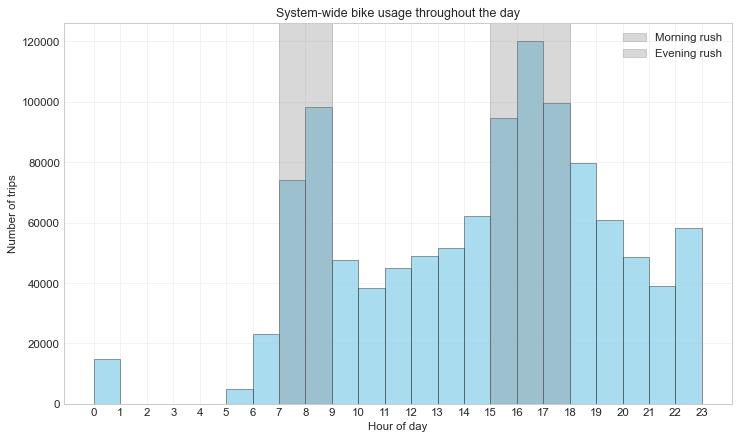

In [153]:
# Add hour to trips table
trips['hour'] = trips['started_at'].dt.hour

plt.hist(trips['hour'], bins=23, color='skyblue', edgecolor='black', alpha=0.7, linewidth=0.5)
plt.axvspan(7, 9, alpha=0.3, color='gray', label='Morning rush')
plt.axvspan(15, 18, alpha=0.3, color='gray', label='Evening rush')

plt.xticks(range(24))
plt.xlabel('Hour of day')
plt.ylabel('Number of trips')
plt.title('System-wide bike usage throughout the day')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

**Figure 9**: Hourly bike usage shows peaks at typical rush hour times. 

### 4.2 When do perpheral stations feed the central ones? Extreme station patterns
Let's first look at how the daily flux of bikes develops throughout the day. We will start by looking at the most extreme stations, wich are the top most exporting and importing stations.  
  
To achieve an overview of the daily pattern in the flux of bikes, we need to group the dataset by 'hour of day' and then count the hourly arrivals and departures. This will give us the average flux behaviour over the entire year, smoothing out any seasonal variations such as winter and summmer or weekends and week days, retaining only variations caused by the time of day.  
  
#### 4.2.1 Top exporters and importers

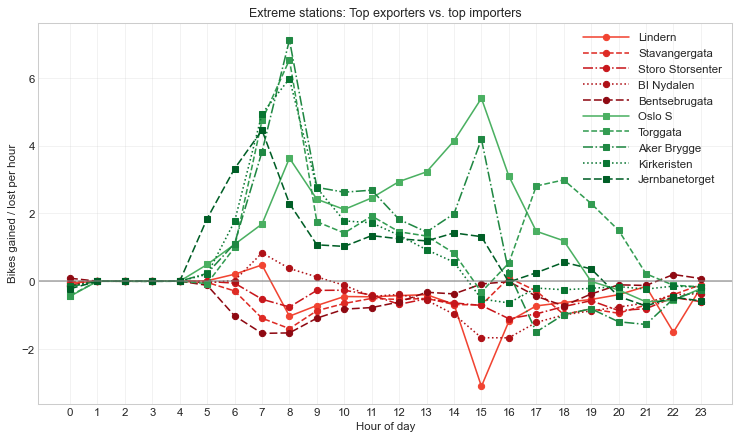

In [154]:
# Calculate hourly flux for each station
hourly_arrivals = trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/365
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Get top n exporters and importers
n = 5
top_importers = station_flux.nlargest(n, 'net_flux_daily')
top_exporters = station_flux.nsmallest(n, 'net_flux_daily')

importer_stations = top_importers['station_id'].tolist()
exporter_stations = top_exporters['station_id'].tolist()

# Plot top exporters and importers

linestyle = ['-', '--', '-.', ':', (0, (5, 2))]
plt.figure()
# Plot exporters
for i, (_, station) in enumerate(top_exporters.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Reds(0.6 + 0.4 * (i / n))
    plt.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])
    
# Plot importers
for i, (_, station) in enumerate(top_importers.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Greens(0.6 + 0.4 * (i / n))
    plt.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])
    
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
plt.xticks(range(24))
plt.xlabel('Hour of day')
plt.ylabel('Bikes gained / lost per hour')
plt.title('Extreme stations: Top exporters vs. top importers')
plt.legend(loc='upper right', handlelength=4)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/imbalanced_stations.png")
plt.savefig("../images/hourly_flux.png", dpi=150, bbox_inches='tight')
plt.show()

**Figure 10**: Hourly bike flux for top 5 importer and exporter stations. Importers (green) show strong morning and afternoon peaks, accumulating bikes throughout the day. Exporters (red) consistently lose bikes with no evening return.

**Key findings**:  
  
**Exporter station** behaviour (red lines - feeder network):  
- **Consistent daily export**: All exporter stations remain largly negative throughout the day, indicating that bikes mainly flow one-way.  
- **Long morning rush (05-09)**  
- **There are some local exceptions:**
    - **Lindern (Ullevål Hospital)**: Brief import spikes at 06-07 and two large export spikes; one at 15:00 (probably hospital day shift ending) and another at 22:00 (evening shift ending).  
    - **BI Nydalen**: Brief import spike at 07-08, probably students and employees arriving at the BI campus. 
- **No evening return**: Confirms that people don't bike back uphill, they use other means of transportation.  
  
**Importer station** behavior (green lines - core network):  
- **Strong morning influx (07-09)**: All downtown stations show large positive spikes, with peakes reaching 6+ bikes per hour net inflow.
- **Sustained high import levels throughout the day**.
- **Variable afternoon patterns (14-17)**:  
    - **Oslo S and Aker Brygge:** Import fluxes spike again, probably because they are major transport hubs and important areas for leisure activities.  
    - **Other core stations**: Show more variable patterns, with some even breifly exporting bikes.  
- **Evening activities:**  
    - **Torggata is the top evening importer:** This area is a popular destination for evening entertainment, dining and drinks. People bike there after work for social activities. 

**Note**: These patterns represent the system behaviour average across the entire year. The true pattern of on any day of the year might be significanlty different, based on seasonal effects (summer/winter), weather conditions (temperature, rain) and day of week (weekend or weekday). Later sections in this analysis will explore these in more detail. 

### 4.3 Balanced stations
Let's now turn our attention to bike stations at intermediate elevations where the bike flow is more balanced.

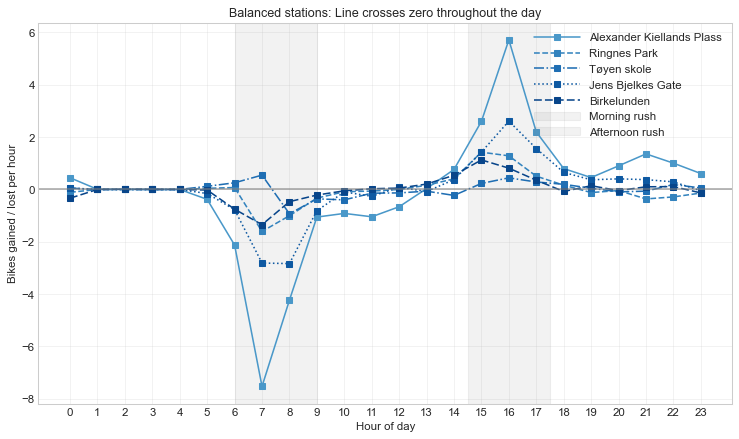

In [155]:
# Get top balanced stations
balanced_stations = station_flux[
    (station_flux['net_flux'].abs() < 500) & # small imbalance
    (station_flux['total_usage'] > 5000)     # high usage
].nlargest(n,'total_usage')

# Plot top balanced stations
linestyle = ['-', '--', '-.', ':', (0, (5, 2))]

plt.figure()
for i, (_, station) in enumerate(balanced_stations.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Blues(0.6 + 0.4 * (i / n))
    plt.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])
    
# Add rush hour shading
plt.axvspan(6, 9, alpha=0.1, color='gray', label='Morning rush')
plt.axvspan(14.5, 17.5, alpha=0.1, color='gray', label='Afternoon rush')
    
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
plt.xticks(range(24))
plt.xlabel('Hour of day')
plt.ylabel('Bikes gained / lost per hour')
plt.title('Balanced stations: Line crosses zero throughout the day')
plt.legend(loc='upper right', handlelength=4)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/balanced_stations.png")
plt.show()

**Figure 11**: Hourly bike flux for top 5 balanced stations. Clear outbound peak in the morning and inbound return peak in the afternoon. 

**Key findings:**  
**Balanced stations have a clear zero-crossing:**  
- Lines cross the `y=0` axis, which indicates a two-way flow.
There is no persistent directional bias. Bikes flow both in and out throughout the day.  
  
**Clear temporal patterns**:
- **Morning outflow (06-09):** These stations show negative spikes, suggesting people leave these areas for work.  
- **Afternoon influx (15-18):** As opposed to importer and exporter stations, here there is a clear sign that commuters actually return home by bike, which causes the large influx spike in the afternoon.  
- **Alexander Kiellands Plass** shows extreme pattern: Dramatic morning exports (-7 bikes/hour) followed by strong afternoon import (6+ bikes/hour). 

### 4.4 Weekday vs. weekend patterns
Let's investigate how the daily flow pattern differs between weekdays and weekends. The question to answer is whether the system is more popular for weekday commutes or weekend leisure rides. The metrics to look into first are the **daily trip count** and the **daily ride duration** for each day of the week. 

#### 4.4.1 Trip count and mean duration
The following plots show the **average number of rides** and the **average trip duration** by day of the week. 

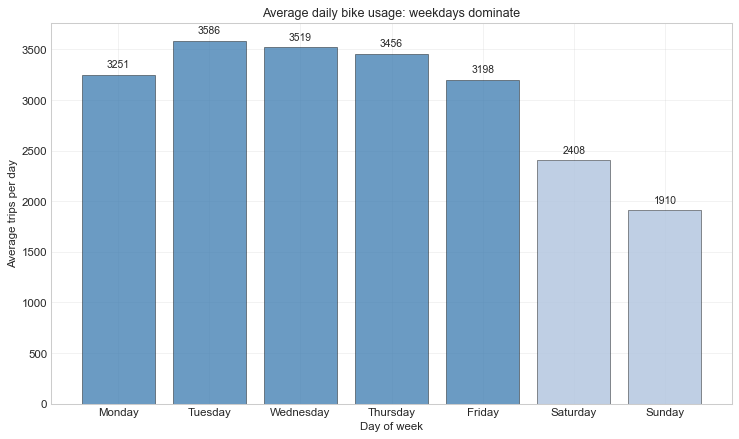

In [156]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips['weekday'] = trips['started_at'].dt.day_name()

weekly_count_stats = trips.groupby('weekday').size() / 52

plt.figure()

colors = {
    'Monday': 'steelblue',
    'Tuesday': 'steelblue', 
    'Wednesday': 'steelblue', 
    'Thursday': 'steelblue', 
    'Friday': 'steelblue', 
    'Saturday': 'lightsteelblue', 
    'Sunday': 'lightsteelblue'}

bars = plt.bar(day_order, [weekly_count_stats[day] for day in day_order],
               color=[colors[day] for day in day_order],
            edgecolor='black', linewidth=0.5, alpha=0.8)

for bar in bars:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    plt.text(x+width/2., height+50, f'{height:.0f}', ha='center',
             va='bottom', fontsize=10)

plt.title("Average daily bike usage: weekdays dominate")
plt.xlabel('Day of week')
plt.ylabel('Average trips per day')
plt.tight_layout()
plt.savefig('../outputs/weekly_usage_count.png')
plt.show()

**Figure 12**: Weekly usage pattern shows weekday trips are more frequent than weekend trips. 

In [157]:
# Compute stats
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekend = ['Saturday', 'Sunday']
weekday_mean = weekly_count_stats.loc[weekday].mean()
weekend_mean = weekly_count_stats.loc[weekend].mean()

difference = (weekday_mean - weekend_mean)/weekday_mean * 100
print(f"Rides on the weekend are {difference:.0f}% less frequent than weekday rides.")

Rides on the weekend are 37% less frequent than weekday rides.


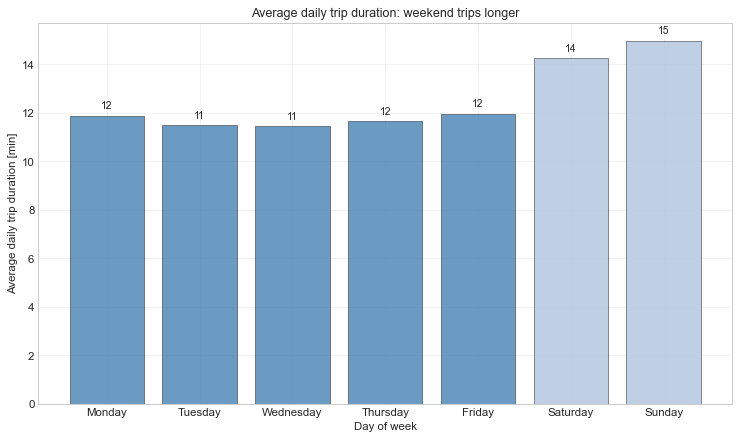

In [158]:
plt.figure()
weekly_duration_stats = trips.groupby('weekday').mean() / 60

bars = plt.bar(day_order, [weekly_duration_stats['duration'][day] for day in day_order],
               color=[colors[day] for day in day_order],
            edgecolor='black', linewidth=0.5, alpha=0.8)

for bar in bars:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    plt.text(x+width/2., height+0.2, f'{height:.0f}', ha='center',
             va='bottom', fontsize=10)
    
plt.title('Average daily trip duration: weekend trips longer')
plt.xlabel('Day of week')
plt.ylabel('Average daily trip duration [min]')
plt.tight_layout()
plt.savefig('../outputs/weekly_usage_duration.png')
plt.show()

**Figure 13**: Weekend trips tend to be longer than weekday trips, indicating more leisurely riding. 

In [159]:
weekday_mean = weekly_duration_stats.loc[weekday,:]['duration'].mean()
weekend_mean = weekly_duration_stats.loc[weekend,:]['duration'].mean()

difference = (weekend_mean - weekday_mean)/weekday_mean * 100
print(f"Rides on the weekend are {difference:.0f}% longer than on weekdays.")

Rides on the weekend are 25% longer than on weekdays.


**Key findings:**  
While intuition might suggest that the bike sharing system is predominantly used for leisure rides, the plots above paint a different picture:
- Rides on the weekend are actually 37% less frequent than on weekdays.
- However, rides on the weekend are on average 25% longer than on weekdays.  
  
This shows that Oslo's bike sharing system is an integrated component in the city's transportation infrastructure, frequently used for commuting purposes. 

#### 4.4.2 Flux analysis
Now let's examine how the station imbalance patterns we identified earlier differ between weekdays and weekends. Using the same net flux analysis from previous sections, I'll split the data by day of the week to see if commuter and leisure behavior creates different flow patterns.

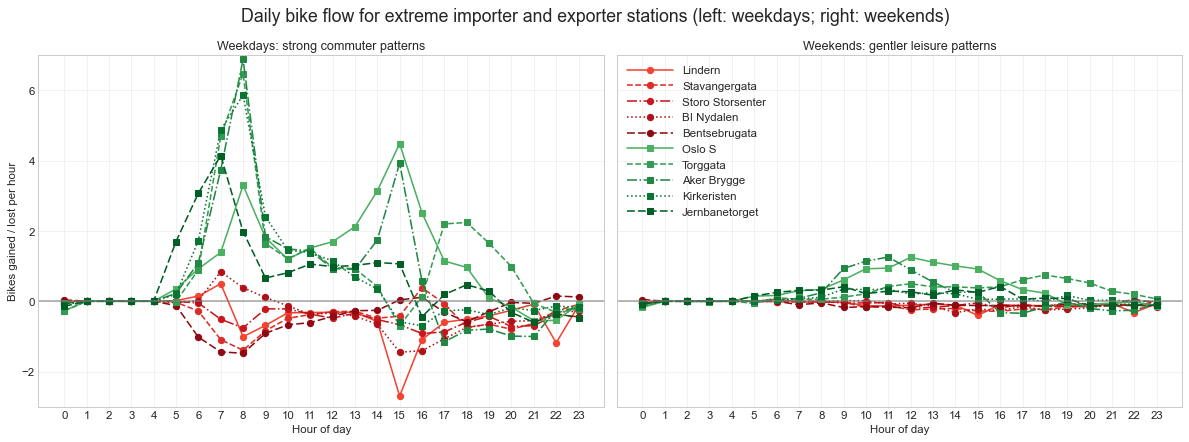

In [160]:
weekend_trips = trips[trips['weekday'].isin(['Saturday', 'Sunday'])]
weekday_trips = trips[~trips['weekday'].isin(['Saturday', 'Sunday'])]

# Create subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

linestyle = ['-', '--', '-.', ':', (0, (5, 2))]

# WEEKDAY PLOT (Left)
# Calculate hourly flux for weekdays
hourly_arrivals = weekday_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekday_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/365
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot exporters on weekday subplot
for i, (_, station) in enumerate(top_exporters.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Reds(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

# Plot importers on weekday subplot
for i, (_, station) in enumerate(top_importers.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Greens(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])

ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax1.set_xticks(range(24))
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Bikes gained / lost per hour')
ax1.set_title('Weekdays: strong commuter patterns')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-3, 7])


# WEEKEND PLOT (Right)
# Calculate hourly flux for weekends
hourly_arrivals = weekend_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekend_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/365
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot exporters on weekend subplot
for i, (_, station) in enumerate(top_exporters.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Reds(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

# Plot importers on weekend subplot
for i, (_, station) in enumerate(top_importers.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Greens(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])

ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax2.set_xticks(range(24))
ax2.set_xlabel('Hour of day')
ax2.set_title('Weekends: gentler leisure patterns')
ax2.grid(True, alpha=0.3)

# Legend
ax2.legend(loc='upper left', handlelength=4)

# Title
plt.suptitle('Daily bike flow for extreme importer and exporter stations (left: weekdays; right: weekends)', fontsize=17)

plt.tight_layout()
plt.savefig('../outputs/weekday_vs_weekend.png', bbox_inches='tight')
plt.show()

**Figure 14**: Comparison of weekday vs. weekend flux patterns for extreme stations. Weekday flux (left) shows strong peaks while weekend patterns (right) are remarkably flat. Major imbalances are primarily a weekday phenomenon.

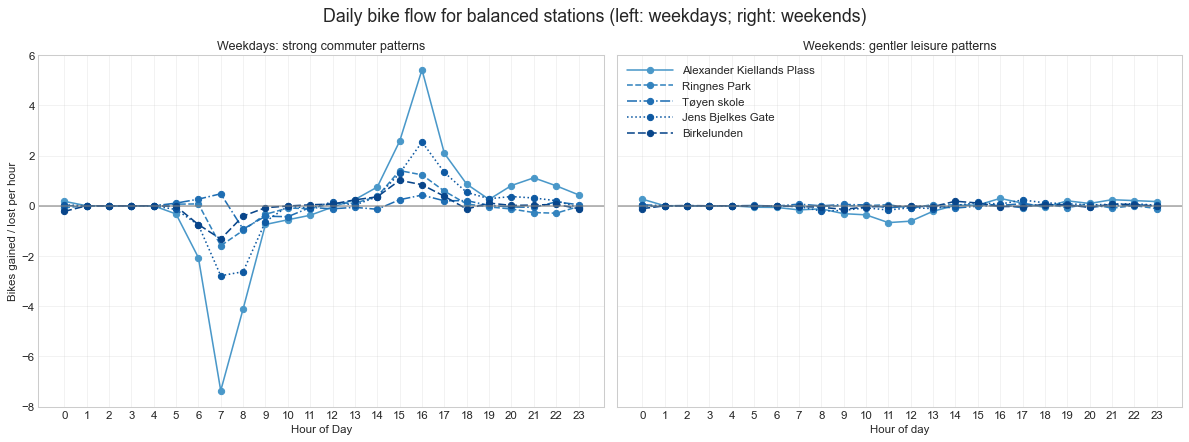

In [161]:
# Create subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# WEEKDAY PLOT (Left)
# Calculate hourly flux for weekdays
hourly_arrivals = weekday_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekday_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/365
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot balanced stations on weekday subplot
linestyle = ['-', '--', '-.', ':', (0, (5, 2))]
for i, (_, station) in enumerate(balanced_stations.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Blues(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax1.set_xticks(range(24))
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Bikes gained / lost per hour')
ax1.set_title('Weekdays: strong commuter patterns')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-8, 6])


# WEEKEND PLOT (Right)
# Calculate hourly flux for weekends
hourly_arrivals = weekend_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekend_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/365
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot balanced stations on weekend subplot
for i, (_, station) in enumerate(balanced_stations.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Blues(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])



ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax2.set_xticks(range(24))
ax2.set_xlabel('Hour of day')
ax2.set_title('Weekends: gentler leisure patterns')
ax2.grid(True, alpha=0.3)

# Legend
ax2.legend(loc='upper left', handlelength=4)

# Title
plt.suptitle('Daily bike flow for balanced stations (left: weekdays; right: weekends)', fontsize=17)

plt.tight_layout()
plt.savefig('../outputs/weekday_vs_weekend_balanced.png', bbox_inches='tight')
plt.show()

**Figure 14**: Balanced stations show clear two-way commuter flows on weekdays (left) with prominent rush hour peaks. Weekend patterns remain flat and balanced throughout the day. 

**Key observations:**
- The weekday flux patterns look almost identical to the earlier analysis of the full dataset. 
- The huge morning exports and afternoon imports are primarily weekday phenomena. 
- Both balanced and extreme stations show only small flux variation throughout the day on weekends.
- Weekend usage tends to be a lot more balanced than weekday usage.  
  
**Note**: A line near zero indicates balanced inflow and outflow of bikes, not necessarily low usage. To understand the actual station activity, we'll reproduce the figures using total usage instead.  

#### 4.4.3 Total usage analysis
A net flux near zero provides information on how many bikes a station gains or loses over a certain period of time. However, it doesn't inform us about how many bikes are used in total, as a large number of incoming bikes and outgoing bikes produce the same result as a small number. In this section, we will reproduce the previous plot, but this time we'll look at the total station usage, as opposed to the bike flux. 

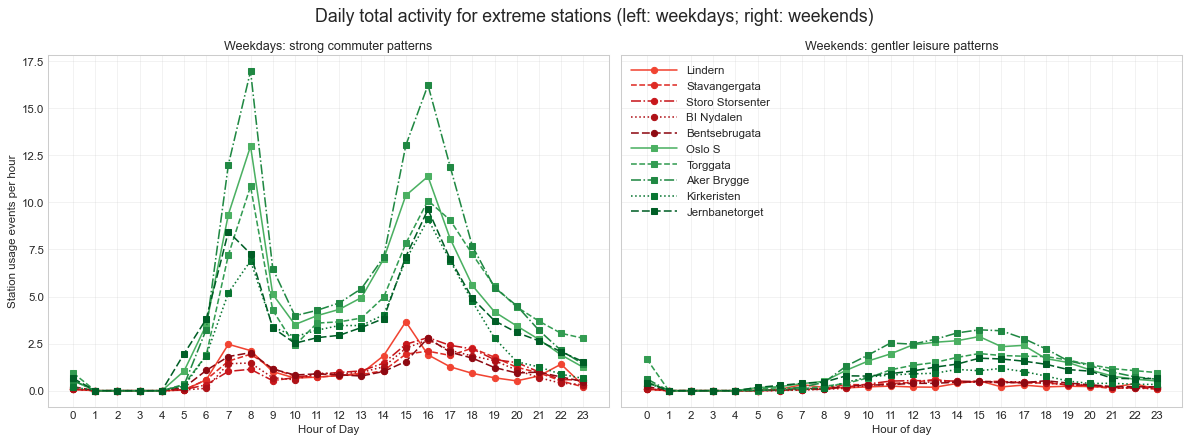

In [162]:
# Create subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# WEEKDAY PLOT (Left)
# Calculate hourly total usage for weekdays
hourly_arrivals = weekday_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekday_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_total_usage = (hourly_arrivals + hourly_departures)/365
hourly_total_usage = hourly_total_usage.reindex(columns=range(24), fill_value=0)

# Plot exporters on weekday subplot
linestyle = ['-', '--', '-.', ':', (0, (5, 2))]
for i, (_, station) in enumerate(top_exporters.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Reds(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_total_usage.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

# Plot importers on weekday subplot
for i, (_, station) in enumerate(top_importers.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Greens(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_total_usage.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])

# ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax1.set_xticks(range(24))
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Station usage events per hour')
ax1.set_title('Weekdays: strong commuter patterns')
ax1.grid(True, alpha=0.3)
# ax1.set_ylim([-3, 7])


# WEEKEND PLOT (Right)
# Calculate hourly total usage for weekends
hourly_arrivals = weekend_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekend_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_total_usage = (hourly_arrivals + hourly_departures)/365
hourly_total_usage = hourly_total_usage.reindex(columns=range(24), fill_value=0)

# Plot exporters on weekend subplot
for i, (_, station) in enumerate(top_exporters.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Reds(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_total_usage.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

# Plot importers on weekend subplot
for i, (_, station) in enumerate(top_importers.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Greens(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_total_usage.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])

ax2.set_xticks(range(24))
ax2.set_xlabel('Hour of day')
ax2.set_title('Weekends: gentler leisure patterns')
ax2.grid(True, alpha=0.3)

# Legend
ax2.legend(loc='upper left', handlelength=4)

# Title
plt.suptitle('Daily total activity for extreme stations (left: weekdays; right: weekends)', fontsize=17)

plt.tight_layout()
plt.savefig('../outputs/weekday_vs_weekend_total_usage.png', bbox_inches='tight')
plt.show()

**Figure 15**: Total usage confirms weekdays dominate the system activity with 4x higher peak volumes than on weekends. 

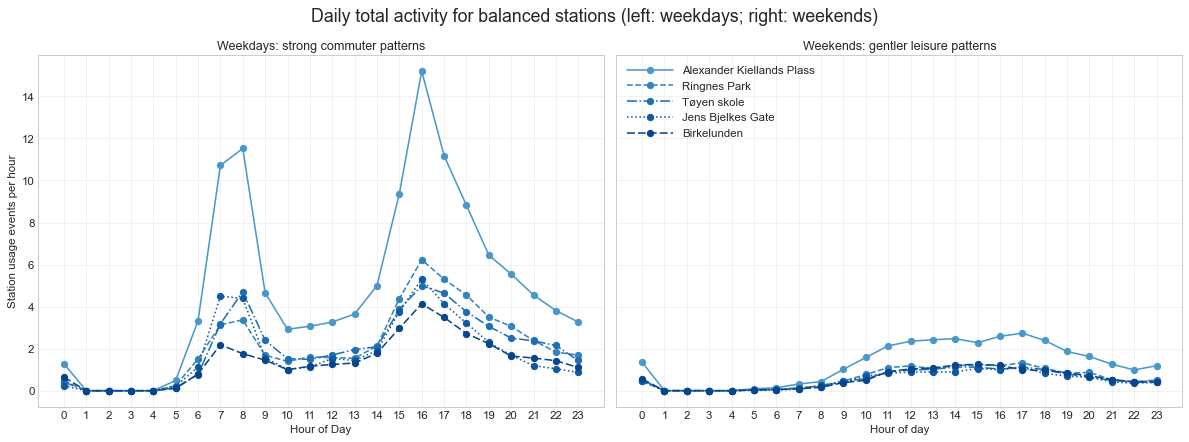

In [163]:

# Create subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# WEEKDAY PLOT (Left)
# Calculate hourly total usage for weekdays
hourly_arrivals = weekday_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekday_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_total_usage = (hourly_arrivals + hourly_departures)/365
hourly_total_usage = hourly_total_usage.reindex(columns=range(24), fill_value=0)

# Plot balanced stations on weekday subplot
linestyle = ['-', '--', '-.', ':', (0, (5, 2))]
for i, (_, station) in enumerate(balanced_stations.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Blues(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_total_usage.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

ax1.set_xticks(range(24))
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Station usage events per hour')
ax1.set_title('Weekdays: strong commuter patterns')
ax1.grid(True, alpha=0.3)
# ax1.set_ylim([-8, 6])


# WEEKEND PLOT (Right)
# Calculate hourly total usage for weekends
hourly_arrivals = weekend_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = weekend_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_total_usage = (hourly_arrivals + hourly_departures)/365
hourly_total_usage = hourly_total_usage.reindex(columns=range(24), fill_value=0)

# Plot balanced stations on weekend subplot
for i, (_, station) in enumerate(balanced_stations.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Blues(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_total_usage.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

ax2.set_xticks(range(24))
ax2.set_xlabel('Hour of day')
ax2.set_title('Weekends: gentler leisure patterns')
ax2.grid(True, alpha=0.3)

# Legend
ax2.legend(loc='upper left', handlelength=4)

# Title
plt.suptitle('Daily total activity for balanced stations (left: weekdays; right: weekends)', fontsize=17)

plt.tight_layout()
plt.savefig('../outputs/weekday_vs_weekend_total_usage_balanced.png', bbox_inches='tight')
plt.show()

**Figure 16**: Even balanced stations show 5x higher weekday peaks compared to weekend activity levels. 

**Key finding:**  
- Central stations handle up to 16 trips per hour during weekday peaks while fewer than 4 per hour on the weekend.  
- Stations that appeared inactive in the flux analysis actually maintain steady 2-3 trips per hour throughout weekends.  
- The flat weekend flux lines actually represented two-way traffic, not low usage.  
- As expected, the rush hour peaks are only a thing on weekdays. 
- Weekend usage is more gentle with less pronounced peaks. 

### 4.5 Summer vs. year-round patterns
The previous analyses used all data throughout the year. Knowing Oslo's climate, it seems natural that most of the bike traffic happens during the summer months. In this section we'll compare how much the bike flow patterns vary between the summer months and the remaining months of the year. 

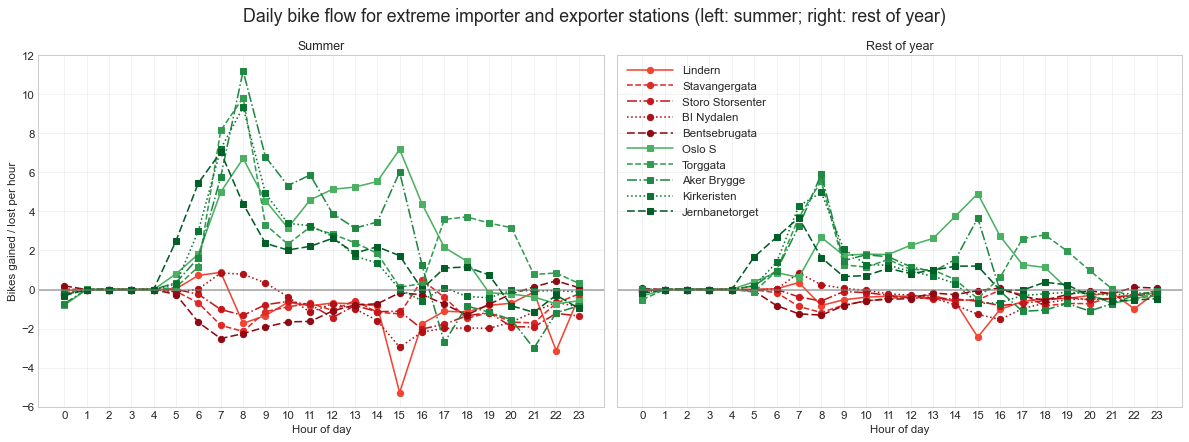

In [164]:
trips['month'] = trips['started_at'].dt.month
summer_trips = trips[trips['month'].isin([6, 7, 8])]
nonsummer_trips = trips[~trips['month'].isin([6, 7, 8])]

# Create subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# SUMMER PLOT (Left)
# Calculate hourly flux for summer
hourly_arrivals = summer_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = summer_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/90
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot exporters in summer subplot
for i, (_, station) in enumerate(top_exporters.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Reds(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

# Plot importers in summer subplot
for i, (_, station) in enumerate(top_importers.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Greens(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])

ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax1.set_xticks(range(24))
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Bikes gained / lost per hour')
ax1.set_title('Summer')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-6, 12])


# REST OF YEAR PLOT (Right)
# Calculate hourly flux for rest of year
hourly_arrivals = nonsummer_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = nonsummer_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/270
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot exporters rest of year subplot
for i, (_, station) in enumerate(top_exporters.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Reds(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

# Plot importers rest of year subplot
for i, (_, station) in enumerate(top_importers.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Greens(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='s', label=station['station_name'])

ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax2.set_xticks(range(24))
ax2.set_xlabel('Hour of day')
ax2.set_title('Rest of year')
ax2.grid(True, alpha=0.3)

# Add single legend to the right
ax2.legend(loc='upper left', handlelength=4)

# Title
plt.suptitle('Daily bike flow for extreme importer and exporter stations (left: summer; right: rest of year)', fontsize=17)

plt.tight_layout()
plt.savefig('../outputs/summer_vs_rest_of_year.png', bbox_inches='tight')
plt.show()

**Figure 18**: Summer amplifies existing patterns 2x but doesn't change the fundamental behavior.

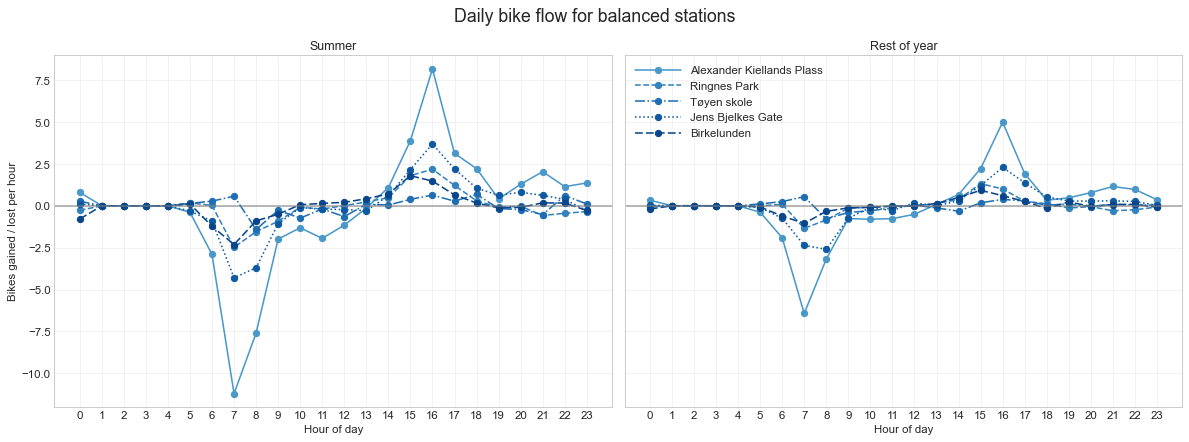

In [165]:
# Create subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# SUMMER PLOT (Left)
# Calculate hourly flux for weekdays
hourly_arrivals = summer_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = summer_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/90
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot balanced stations in summer subplot
linestyle = ['-', '--', '-.', ':', (0, (5, 2))]
for i, (_, station) in enumerate(balanced_stations.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Blues(0.6 + 0.4 * (i / n))
    ax1.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])

ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax1.set_xticks(range(24))
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Bikes gained / lost per hour')
ax1.set_title('Summer')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-12, 9])


# REST OF YEAR PLOT (Right)
# Calculate hourly flux for rest of year
hourly_arrivals = nonsummer_trips.groupby(['end_station_id', 'hour']).size().unstack(fill_value=0)
hourly_departures = nonsummer_trips.groupby(['start_station_id', 'hour']).size().unstack(fill_value=0)
hourly_net_flux = (hourly_arrivals - hourly_departures)/270
hourly_net_flux = hourly_net_flux.reindex(columns=range(24), fill_value=0)

# Plot balanced stations for rest of year subplot
for i, (_, station) in enumerate(balanced_stations.iterrows()):
    station_id = station['station_id']
    color = plt.cm.Blues(0.6 + 0.4 * (i / n))
    ax2.plot(range(24), hourly_net_flux.loc[station_id], c=color, 
             linestyle=linestyle[i], marker='o', label=station['station_name'])



ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
ax2.set_xticks(range(24))
ax2.set_xlabel('Hour of day')
ax2.set_title('Rest of year')
ax2.grid(True, alpha=0.3)

# Legend
ax2.legend(loc='upper left', handlelength=4)

# Title
plt.suptitle('Daily bike flow for balanced stations', fontsize=17)

plt.tight_layout()
plt.savefig('../outputs/summer_vs_rest_of_year_balanced.png', bbox_inches='tight')
plt.show()

**Figure 19**: Summer intensifies balanced station patterns while preserving the same bidirectional commuter flows. 

**Key findings**:
- Summer amplifies the flux patterns but doesn't change the fundamental behavior.
- Central stations reach flux peaks of 11+ bikes/hour in summer vs. 5-6 during the rest of the year.
- The same morning export and afternoon import patterns persist year-round, just at different intensities. 

### 4.6 Summary: Temporal insights
The temporal analysis showed that bike stations follow distinctive and predictable daily and weekly patterns.  
  
First of all, **weekdays dominate** the system usage. Trips are 37% more frequent during the week than on weekends, and the daily patterns show very different behavior. On weekdays, stations can be classified into one of three categories:
- **Exporter stations**: Consistently lose bikes with no evening return flow
- **Importer stations**: Accumulate bikes throughout weekday mornings and evenings
- **Balanced stations**: Show two-way commuter flows with morning export peak and afternoon import peak
  
Secondly, seasonal and weekly variations follow predictable patterns:
- Leisure riding on weekends flattens all imbalances and creates gentler flows.
- Summer amplifies existing patterns without changing the fundamental behavior.
  
These patterns demonstrate the daily challenges to redistribute bikes such that they are available for morning commutes and ensure docking capacity to end rides. 

---
## 5. Conclusions

This analysis set out to understand how Oslo's bike sharing system really works. It turned out that the movement of bikes is not completely random, but is in fact guided by very predictable patterns. Three important aspects control the movements of bikes around town.  
  
The **gravity problem**: The topographical analysis showed that cyclists have a strong preference for downhill over uphill travel. 59.6% of all rides go downhill while only 38.8% go uphill. People tend to ride bikes from higher elevations down to lower elevations in the city center, and then take other means of transportation back home. This leads to a depletion of bikes at elevations over ~35 meters, and stations lower than that consistently accumulate bikes. Without proper countermeasures, uphill stations would soon run out of bikes while downhill stations would run out of docking capacity.  
  
**Two-zone structure**: The network analysis showed that the network can be divided into two parts. The first is the **core network** in downtown areas where most of the rides take place. This area acts as a bike sink where stations such as Aker Brygge, Oslo S and Torggata persistently import bikes throughout the day. Surrounding this core network is the **feeder network** of peripheral stations, which primarily export bikes downhill each day. The most popular routes fall into two categories: Short waterfront leisure rides and high-frequency commuter rides between major downtown hubs.  
  
**Weekday travel dominates:** The temporal analysis showed that weekdays dominate the bike-sharing network. Weekday trips are 37% more frequent than weekend trips. Different stations show very different bike fluxes throughout the day. Balanced stations function as large bike exporters in the morning and as large importers in the evening. Downtown stations are mainly importers throughout the entire day, while peripheral stations mainly export. This pattern is much less extreme on weekends and becomes flattened. 
  
These three effects drive the bike flow in Oslo. Understanding these patterns shows that bike rebalancing in Oslo isn't random maintenance, but a daily battle against gravity. Restocking and bike removal needs follow predictable patterns controlled by time and location. Oslo Bysykkel clearly does a great job managing these challenges. The system works well despite the difficult topography. With insights like these, operators could potentially schedule their trucks even more efficiently and predict which stations will be empty by rush hour, and maybe even prevent those frustrating moments when you can't find a bike or a place to park one.
  
This was a fun weekend project and shows the power of data science. Analyses like this allow us to extract patterns from seemingly random datasets and provide answers to concrete questions. 